In [19]:
# System management 
import os
import time
import pickle
import dill
from collections import Counter
import gzip
import io

# Data manipulation
import numpy as np
import pandas as pd
import re
pd.options.display.max_rows = 400

# Scikit-learn
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, classification_report
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFECV

# Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm 
from xgboost import XGBClassifier

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
from hyperopt.pyll.base import scope

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# MLFlow tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns
plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })
%matplotlib inline
sns.set_theme(palette='Set1')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Set main directory
project_path = '/Users/felipelima/Documents/projets/credit-scoring/'
os.chdir(project_path)

In [21]:
# Load data
with gzip.open('data/processed/train_feature_engineering_encoded.csv.gz', 'rb') as file:
    content = file.read()

    data = pd.read_csv(io.StringIO(content.decode('utf-8'))).drop(columns=['SK_ID_CURR'])
data.head()

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1                   0            0             0                0   
1       0                   0            1             0                1   
2       0                   1            0             1                0   
3       0                   0            1             0                0   
4       0                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0           0.0          202500.0    406597.5      24700.5   
1           0.0          270000.0   1293502.5      35698.5   
2           0.0           67500.0    135000.0       6750.0   
3           0.0          135000.0    312682.5      29686.5   
4           0.0          121500.0    513000.0      21865.5   

   REGION_POPULATION_RELATIVE  ...  CC_NAME_CONTRACT_STATUS_Signed_MIN  \
0                    0.018800  ...                                   0   
1                    0.003542  ...                                   0   
2                    0.010030  ...                                   0   
3                    0.008020  ...                                   0   
4                    0.028660  ...                                   0   

   CC_NAME_CONTRACT_STATUS_Signed_MAX  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                   0                                  0.0   
1                                   0                                  0.0   
2                                   0                                  0.0   
3                                   0                                  0.0   
4                                   0                                  0.0   

   CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                 0.0                                 0.0   
1                                 0.0                                 0.0   
2                                 0.0                                 0.0   
3                                 0.0                                 0.0   
4                                 0.0                                 0.0   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               0.0                              0.0   
1                               0.0                              0.0   
2                               0.0                              0.0   
3                               0.0                              0.0   
4                               0.0                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_VAR  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  

[5 rows x 575 columns]

#### MLFlow 

Set MLFlow tracking

In [22]:
# Create experiment
experiment_name = 'credit_scoring'
# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)
# If the experiment doesn't exist, create it
if experiment is None: 
    mlflow.create_experiment(experiment_name)
# Set the experiment 
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/felipelima/Documents/projets/credit-scoring/mlruns/373801358020512024', creation_time=1702705177514, experiment_id='373801358020512024', last_update_time=1702705177514, lifecycle_stage='active', name='credit_scoring', tags={}>

#### Data pre-processing

In [23]:
# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

##### Missing values

Fill the missing values with a simple imputer

In [24]:
# Check missing values
nan_values = data.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

inf_values = np.isinf(data).values.sum()
print('Infinite values = {} ({:.2%})'.format(inf_values, inf_values/data.size))

Missing values = 0 (0.00%)
Infinite values = 0 (0.00%)


In [25]:
data = data.replace([np.inf, -np.inf], np.nan)

In [26]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET]
features = data.drop(columns=TARGET)
features_names = data.drop(columns=TARGET).columns.to_list()

In [27]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)
features_fill = pd.DataFrame(features_fill, columns=features_names)

In [28]:
nan_values = features_fill.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 0 (0.00%)


#### Standardisation

In [29]:
scaler = StandardScaler()

features_fill = scaler.fit_transform(features_fill)
features_fill = pd.DataFrame(features_fill, columns=features_names)

features_fill.head()

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           -0.324374    -1.388168     -0.717907        -0.664534   
1           -0.324374     0.720374     -0.717907         1.504814   
2            3.082864    -1.388168      1.392939        -0.664534   
3           -0.324374     0.720374     -0.717907        -0.664534   
4           -0.324374    -1.388168     -0.717907        -0.664534   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0     -0.577535          0.142128   -0.478098    -0.166144   
1     -0.577535          0.426789    1.725434     0.592682   
2     -0.577535         -0.427193   -1.152886    -1.404670   
3     -0.577535         -0.142532   -0.711431     0.177873   
4     -0.577535         -0.199465   -0.213739    -0.361750   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
0                   -0.149559    1.506194  ...   
1                   -1.252640   -0.167965  ...   
2                   -0.783588   -0.688132  ...   
3                   -0.928902   -0.678966  ...   
4                    0.563271   -0.894366  ...   

   CC_NAME_CONTRACT_STATUS_Signed_MIN  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                           -0.010202                           -0.118961   
1                           -0.010202                           -0.118961   
2                           -0.010202                           -0.118961   
3                           -0.010202                           -0.118961   
4                           -0.010202                           -0.118961   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                            -0.062025                           -0.045826   
1                            -0.062025                           -0.045826   
2                            -0.062025                           -0.045826   
3                            -0.062025                           -0.045826   
4                            -0.062025                           -0.045826   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                           -0.079212                              0.0   
1                           -0.079212                              0.0   
2                           -0.079212                              0.0   
3                           -0.079212                              0.0   
4                           -0.079212                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  
0                              0.0                              0.0  
1                              0.0                              0.0  
2                              0.0                              0.0  
3                              0.0                              0.0  
4                              0.0                              0.0  

[5 rows x 574 columns]

#### Split data

In [30]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(246004, 574) (246004,)
(61502, 574) (61502,)


#### Data distribution

In [31]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test)
print('Training target statistics:', y_train_counter)
print('Testing target statistics:', y_test_counter)

# Print ratio
print('Ratio is 1:{:.0f} in training/validation set'.format(y_train_counter[0] / y_train_counter[1]))
print('Ratio is 1:{:.0f} in test set'.format(y_test_counter[0] / y_test_counter[1]))

Training target statistics: Counter({0: 226154, 1: 19850})
Testing target statistics: Counter({0: 56527, 1: 4975})
Ratio is 1:11 in training/validation set
Ratio is 1:11 in test set


In [32]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print('Training target statistics:', Counter(y_res))
print('Ratio is 1:{:.0f} in training/validation set'.format(Counter(y_res)[0] / Counter(y_res)[1]))
print('Validation target statistics:', Counter(y_test))
print('Ratio is 1:{:.0f} in test set'.format(Counter(y_test)[0] / Counter(y_test)[1]))

Training target statistics: Counter({0: 113077, 1: 113077})
Ratio is 1:1 in training/validation set
Validation target statistics: Counter({0: 56527, 1: 4975})
Ratio is 1:11 in test set


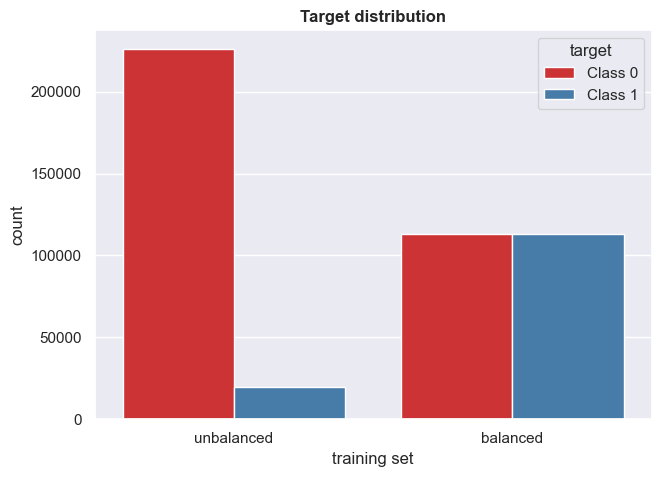

In [33]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title('Target distribution')
plt.show()

The resulting data is now balanced. However, since we will test using cross validation, the resampling step shall be done for each cross validation iteration (inside the pipeline).

#### Metric functions

In [34]:
# 1 --> dont repay
# 0 --> repay
# Custom loss function based on business rule =  
# cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)
def business_loss_func(y_true, y_pred): # 1 --> best # 0 --> worst
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tn_rate, tp_rate, fp_rate, fn_rate = 1, 1, -1, -10

    total_default = tp + fn
    total_not_default = tn + fp

    total_gain = tn*tn_rate + tp*tp_rate + fp*fp_rate + fn*fn_rate
    min_gain = total_not_default*tn_rate + total_default*fn_rate
    max_gain = total_not_default*tn_rate + total_default*tp_rate

    score = (total_gain - min_gain) / (max_gain - min_gain)

    return score
business_scorer = make_scorer(business_loss_func, greater_is_better=True)

def specificity_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity
specificity_scorer = make_scorer(specificity_score_func, greater_is_better=True)

def false_positive_rate_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr
fpr_scorer = make_scorer(false_positive_rate_score_func, greater_is_better=False)

#### Classification

In [35]:
def plot_cf_matrix_roc_curve(y_true, y_pred, y_pred_proba, feature_importance=None):
    fig = plt.figure(figsize=(20,15))
    # Left subplot - Confusion Matrix
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    # Right subplot - ROC curve
    plt.subplot(222)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [36]:
def train_model(name, model, X=x_train, y=y_train, cv=5, fast_train=None, log=True):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train 
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE, stratify=y)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Perform cross-validation with the best model (with or without hyperparameter opt)
    t0 = time.time() 
    scores = cross_validate(pipeline, x_train, y_train, cv=strat_kf, scoring=scoring, n_jobs=-1)
    print(scores)

    # Get train / validation metrics
    for score in scoring.keys():
        results_cv[score] = scores[f'test_{score}'].mean()
    results_cv['fit_time'] = scores['fit_time'].mean()
    results_cv['execution_time'] = time.time() - t0

    # Fit / train with training set
    t0 = time.time()
    pipeline.fit(x_train, y_train)
    results_test['fit_time'] = time.time() - t0

    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    y_pred_proba = pipeline.predict_proba(x_test)[:, 1]

    # Calculate test metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)
    
    # Plot confusion matrix and roc curve
    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)

    if log == True: 
    # Save logs
        with mlflow.start_run(run_name=name):
            # Set parameters
            for param, value in model.get_params().items():
                mlflow.log_param(param, value)

            # Set train / validation metrics
            mlflow.log_metric('validation_business_score', results_cv['business_score'])
            mlflow.log_metric('validation_auc', results_cv['roc_auc'])
            mlflow.log_metric('validation_f1', results_test['f1'])
            mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
            mlflow.log_metric('validation_precision', results_cv['precision'])
            mlflow.log_metric('validation_recall', results_cv['recall'])
            mlflow.log_metric('validation_specificity', results_cv['specificity'])
            mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
            mlflow.log_metric('validation_fit_time', results_cv['fit_time'])
            mlflow.log_metric('validation_execution_time', results_cv['execution_time'])

            # Set test metrics
            mlflow.log_metric('test_business_score', results_test['business_score'])
            mlflow.log_metric('test_auc', results_test['roc_auc'])
            mlflow.log_metric('test_f1', results_test['f1'])
            mlflow.log_metric('test_accuracy', results_test['accuracy'])
            mlflow.log_metric('test_precision', results_test['precision'])
            mlflow.log_metric('test_recall', results_test['recall'])
            mlflow.log_metric('test_specificity', results_test['specificity'])
            mlflow.log_metric('test_false_positive_rate', results_test['fpr'])
            mlflow.log_metric('test_fit_time', results_test['fit_time'])
            
            # Save model to artifacts
            mlflow.sklearn.log_model(model, name)

    return pipeline, results_cv, results_test

In [37]:
def search_hyperparameters(name, model, X=x_train, y=y_train, cv=5, param_grid=None, fast_train=None, random=True, n_iter=10):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train / hyperparameter optmization
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    # Perform hyperparameter tuning using RandomizedSearchCV or GridSearchCV
    t0 = time.time()
    if random == True:
        grid_searcher = RandomizedSearchCV(pipeline, param_grid, cv=strat_kf, scoring=scoring, n_jobs=-1, random_state=RANDOM_STATE, refit='business_score', verbose=3, n_iter=n_iter)
    else:  
        grid_searcher= GridSearchCV(pipeline, param_grid,  cv=strat_kf, scoring=scoring, n_jobs=-1, refit='business_score', verbose=3)

    grid_searcher.fit(x_train, y_train) 
    best_model = grid_searcher.best_estimator_
    best_params = grid_searcher.best_params_
    best_index = grid_searcher.cv_results_['params'].index(grid_searcher.best_params_)
    for score in scoring.keys():
        results_cv[score] = grid_searcher.cv_results_['mean_test_' + score][best_index]
    results_cv['search_time'] = time.time() - t0

    # Predict on the test set
    y_pred = best_model.predict(x_test)
    y_pred_proba = best_model.predict_proba(x_test)[:, 1]

    # Calculate validation metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)

    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)
    
    # Get constant hyperparameters
    model_params = list(model.get_params().keys())
    variable_params = list(param_grid.keys())
    variable_params = [param[len('classifier__'):] for param in variable_params]
    constant_params = [param for param in model_params if param not in variable_params]

    # Start MLFlow run 
    with mlflow.start_run(run_name=name) as parent_run:
        # Loop through each iteration of RandomizedSearchCV
        for i, params in enumerate(grid_searcher.cv_results_['params']):
            with mlflow.start_run(run_name='RandomizedSearchCV_'+str(i), nested=True) as child_run:
                # Set constant parameters
                for param, value in model.get_params().items():
                    if param in constant_params: 
                        mlflow.log_param(param, value)
                # Set variable parameters
                params = {key[len('classifier__'):]: value for key, value in params.items()}
                mlflow.log_params(params)

                # Set validation metrics
                mlflow.log_metric('validation_business_score', grid_searcher.cv_results_['mean_test_business_score'][i])
                mlflow.log_metric('validation_auc', grid_searcher.cv_results_['mean_test_roc_auc'][i])
                mlflow.log_metric('validation_f1', grid_searcher.cv_results_['mean_test_f1'][i])
                mlflow.log_metric('validation_accuracy', grid_searcher.cv_results_['mean_test_accuracy'][i])
                mlflow.log_metric('validation_precision', grid_searcher.cv_results_['mean_test_precision'][i])
                mlflow.log_metric('validation_recall', grid_searcher.cv_results_['mean_test_recall'][i])
                mlflow.log_metric('validation_specificity', grid_searcher.cv_results_['mean_test_specificity'][i])
                mlflow.log_metric('validation_false_positive_rate', grid_searcher.cv_results_['mean_test_fpr'][i])
                mlflow.log_metric('validation_fit_time', grid_searcher.cv_results_['mean_fit_time'][i])
                mlflow.log_metric('validation_score_time', grid_searcher.cv_results_['mean_score_time'][i])

        # Save information for best model
        # Set constant parameters
        for param, value in model.get_params().items():
            if param in constant_params: 
                mlflow.log_param(param, value)
                
        # Set variable parameters
        best_params = {key[len('classifier__'):]: value for key, value in best_params.items()}
        mlflow.log_params(best_params)

        # Set train / validation metrics
        mlflow.log_metric('validation_business_score', results_cv['business_score'])
        mlflow.log_metric('validation_auc', results_cv['roc_auc'])
        mlflow.log_metric('validation_f1', results_test['f1'])
        mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
        mlflow.log_metric('validation_precision', results_cv['precision'])
        mlflow.log_metric('validation_recall', results_cv['recall'])
        mlflow.log_metric('validation_specificity', results_cv['specificity'])
        mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
        mlflow.log_metric('search_time', results_cv['search_time'])

        # Set test metrics
        mlflow.log_metric('test_business_score', results_test['business_score'])
        mlflow.log_metric('test_auc', results_test['roc_auc'])
        mlflow.log_metric('test_f1', results_test['f1'])
        mlflow.log_metric('test_accuracy', results_test['accuracy'])
        mlflow.log_metric('test_precision', results_test['precision'])
        mlflow.log_metric('test_recall', results_test['recall'])
        mlflow.log_metric('test_specificity', results_test['specificity'])
        mlflow.log_metric('test_false_positive_rate', results_test['fpr'])

        # Save model to artifacts
        mlflow.sklearn.log_model(best_model, name)

    return best_model, results_cv, results_test


In [39]:
def plot_metrics(results_cv, results_test, metrics): 
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Metrics Comparison', fontsize=16)

    # Pastel colors
    pastel_colors = ['#FF6666', '#FFCC99', '#99FF99', '#66B2FF', '#C2C2F0', '#999966', '#FF69B4', '#B19CD9']

    # Models to remove x-axis and y-axis labels
    no_x_labels = []#['DummyClassifier', 'LogisticRegression', 'RandomForest']
    no_y_labels = []#['LogisticRegression', 'RandomForest', 'LightGBM', 'CatBoost']

    # Iterate over models and plot metrics
    for i, model in enumerate(results_cv.keys()):
        metrics_dict = results_cv[model]
        test_metrics_dict = results_test[model]
        ax = axs[i // 3, i % 3]

        x = np.arange(len(metrics))
        width = 0.4

        # Train bars
        train_metrics = [metrics_dict[metric] for metric in metrics]
        ax.bar(x - width/2, train_metrics, width, label='Train', color=pastel_colors, alpha=0.7)

        # Test bars
        test_metrics = [test_metrics_dict[metric] for metric in metrics]
        ax.bar(x + width/2, test_metrics, width, label='Test', color='gray', alpha=0.7)

        ax.set_title(model)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45)
        ax.set_ylim(0, 1)

        if model in no_x_labels:
            ax.set_xticklabels([])

        if model in no_y_labels:
            ax.set_yticklabels([])

    # Adjust subplot layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Add a legend
    axs[1, 2].legend(loc='upper right')

    # Show the plots
    plt.show()

#### Modelling

For the sake of computation, we will use 20% of the data

##### DummyClassifier (= baseline 0)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
{'fit_time': array([4.38445807, 4.22271895, 4.4623239 , 4.5683248 , 4.61960411]), 'score_time': array([0.06847525, 0.09175491, 0.04863095, 0.03176808, 0.03745365]), 'test_accuracy': array([0.49390244, 0.49237805, 0.49034553, 0.49390244, 0.48869411]), 'test_precision': array([0.07916562, 0.0776577 , 0.07564715, 0.07916562, 0.07413923]), 'test_recall': array([0.49606299, 0.48661417, 0.47401575, 0.49606299, 0.46383648]), 'test_f1': array([0.13654096, 0.13394018, 0.13047248, 0.13654096, 0.12784399]), 'test_roc_auc': array([0.49488793, 0.48974898, 0.48289705, 0.49488793, 0.47735771]), 'test_specificity': array([0.49371286, 0.49288379, 0.49177836, 0.49371286, 0.49087894]), 'test_fpr': array([-0.50628714, -0.50711621, -0.50822164, -0.50628714, -0.50912106]), 'test_business_score': array([-0.55304223, -0.56420902, -0.57909807, -0.55304223, -0.58933676])}


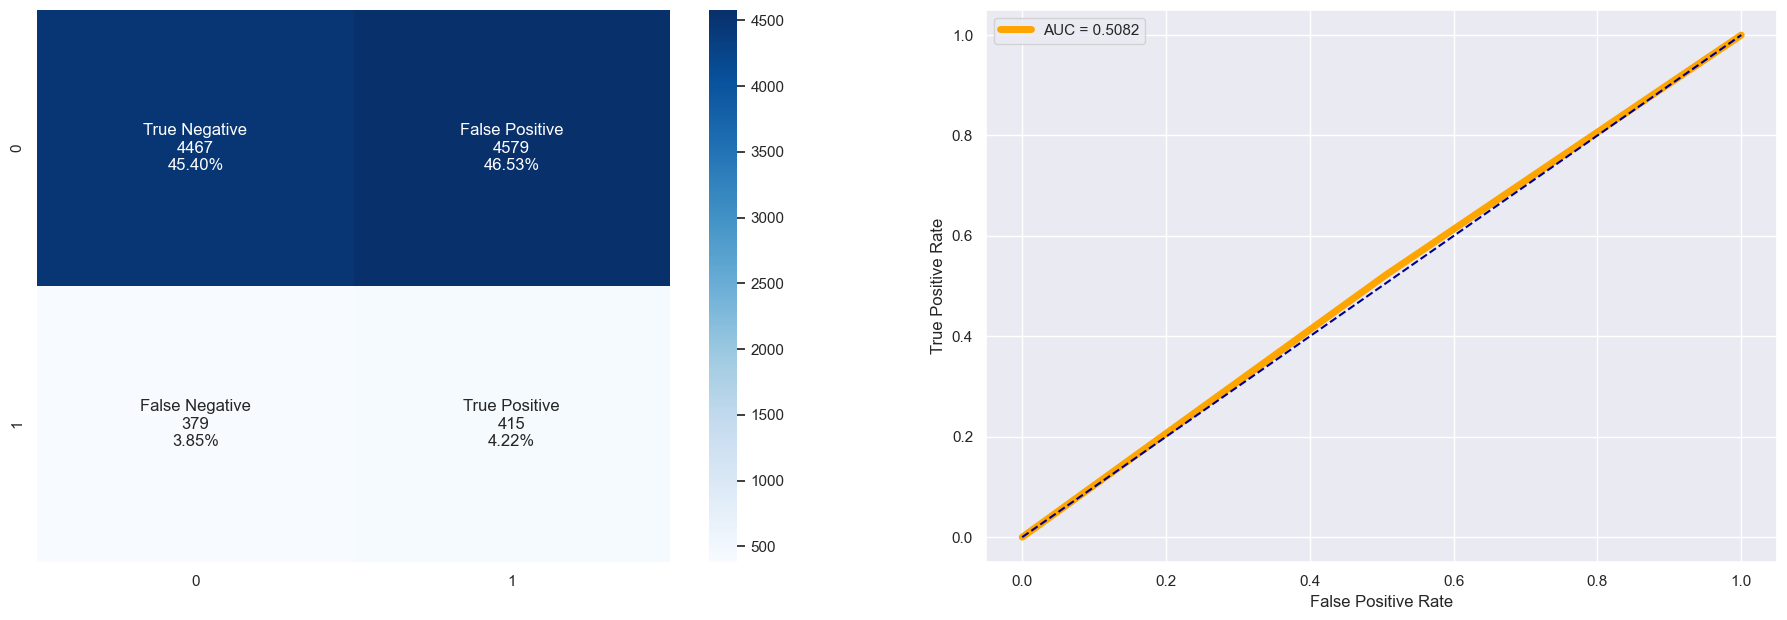

In [40]:
%time
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Compute results 
dc_model, dc_results_cv, dc_results_test = train_model(dc_name, dc, cv=5, fast_train=0.2)

##### Logistical regression (= baseline 1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

{'fit_time': array([10.50164509, 10.41617584,  9.47239399, 10.14271998,  9.47550583]), 'score_time': array([0.07160902, 0.08029008, 0.09731674, 0.08933306, 0.12690997]), 'test_accuracy': array([0.72027439, 0.72141768, 0.71747967, 0.71277947, 0.71316057]), 'test_precision': array([0.17065994, 0.16422414, 0.17074182, 0.16652994, 0.16066946]), 'test_recall': array([0.63937008, 0.6       , 0.6488189 , 0.63937008, 0.60377358]), 'test_f1': array([0.26940942, 0.25786802, 0.27034121, 0.2642369 , 0.2538004 ]), 'test_roc_auc': array([0.72694302, 0.72551771, 0.74711408, 0.73862881, 0.72062273]), 'test_specificity': array([0.72737322, 0.7320713 , 0.72350421, 0.71922067, 0.72277501]), 'test_fpr': array([-0.27262678, -0.2679287 , -0.27649579, -0.28077933, -0.27722499]), 'test_business_score': array([0.07444524, 0.04481031, 0.07587688, 0.0575519 , 0.03030303])}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


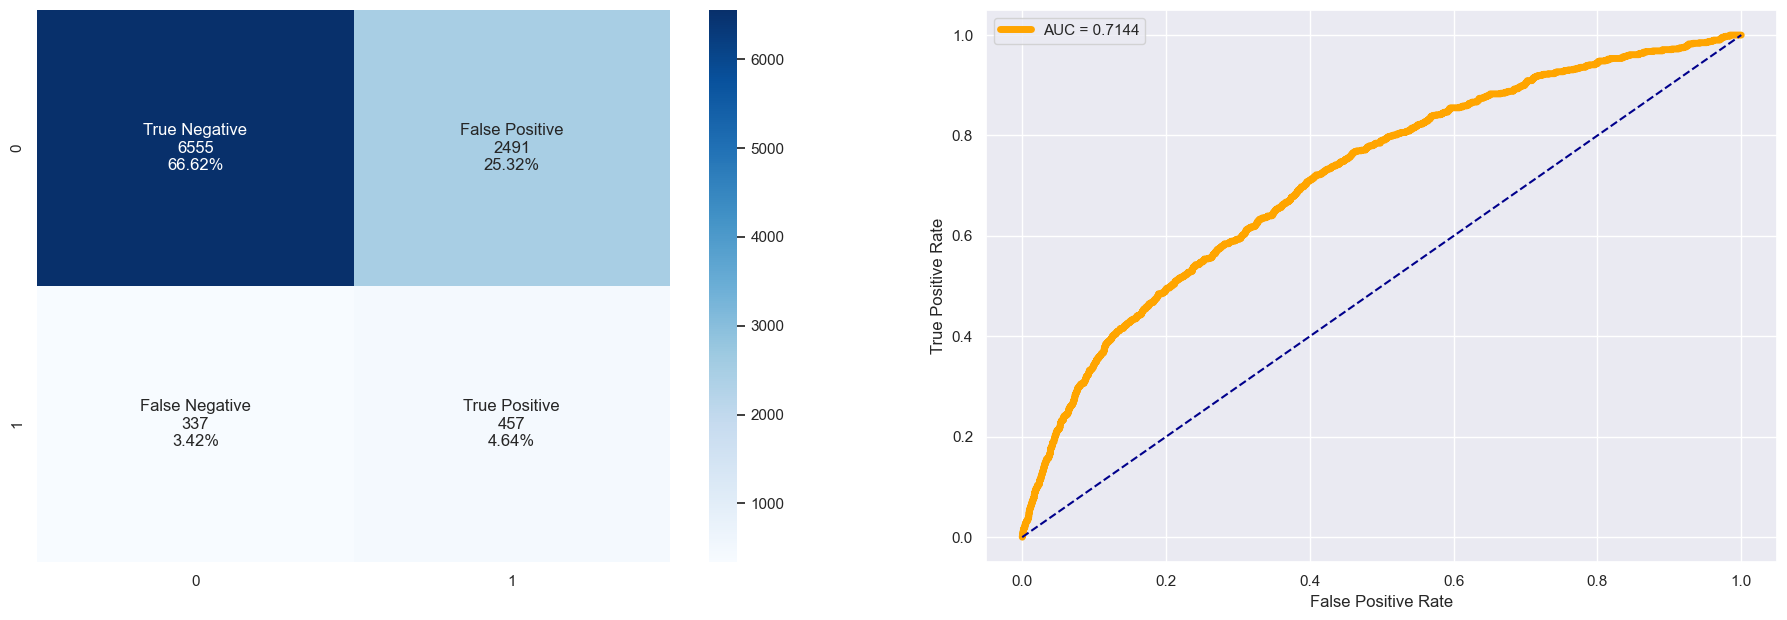

In [41]:
%time
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lr_name = 'LogisticRegression'

# Compute results 
lr_model, lr_results_cv, lr_results_test = train_model(lr_name, lr, cv=5, fast_train=0.2)

##### RandomForest

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.96 µs
{'fit_time': array([36.18340087, 35.76837301, 36.28855395, 36.2398572 , 36.8206737 ]), 'score_time': array([0.47735906, 0.23773384, 0.46907115, 0.47588396, 0.34543324]), 'test_accuracy': array([0.90777439, 0.90815549, 0.90993394, 0.90688516, 0.9109502 ]), 'test_precision': array([0.2208589 , 0.23493976, 0.27160494, 0.2183908 , 0.29813665]), 'test_recall': array([0.05669291, 0.06141732, 0.06929134, 0.05984252, 0.0754717 ]), 'test_f1': array([0.09022556, 0.09737828, 0.11041405, 0.09394314, 0.12045169]), 'test_roc_auc': array([0.69367195, 0.7010531 , 0.71818215, 0.72567939, 0.69359537]), 'test_specificity': array([0.98245129, 0.98245129, 0.9836949 , 0.98120768, 0.98438364]), 'test_fpr': array([-0.01754871, -0.01754871, -0.0163051 , -0.01879232, -0.01561636]), 'test_business_score': array([0.02032928, 0.02505369, 0.03550465, 0.02090193, 0.04316752])}


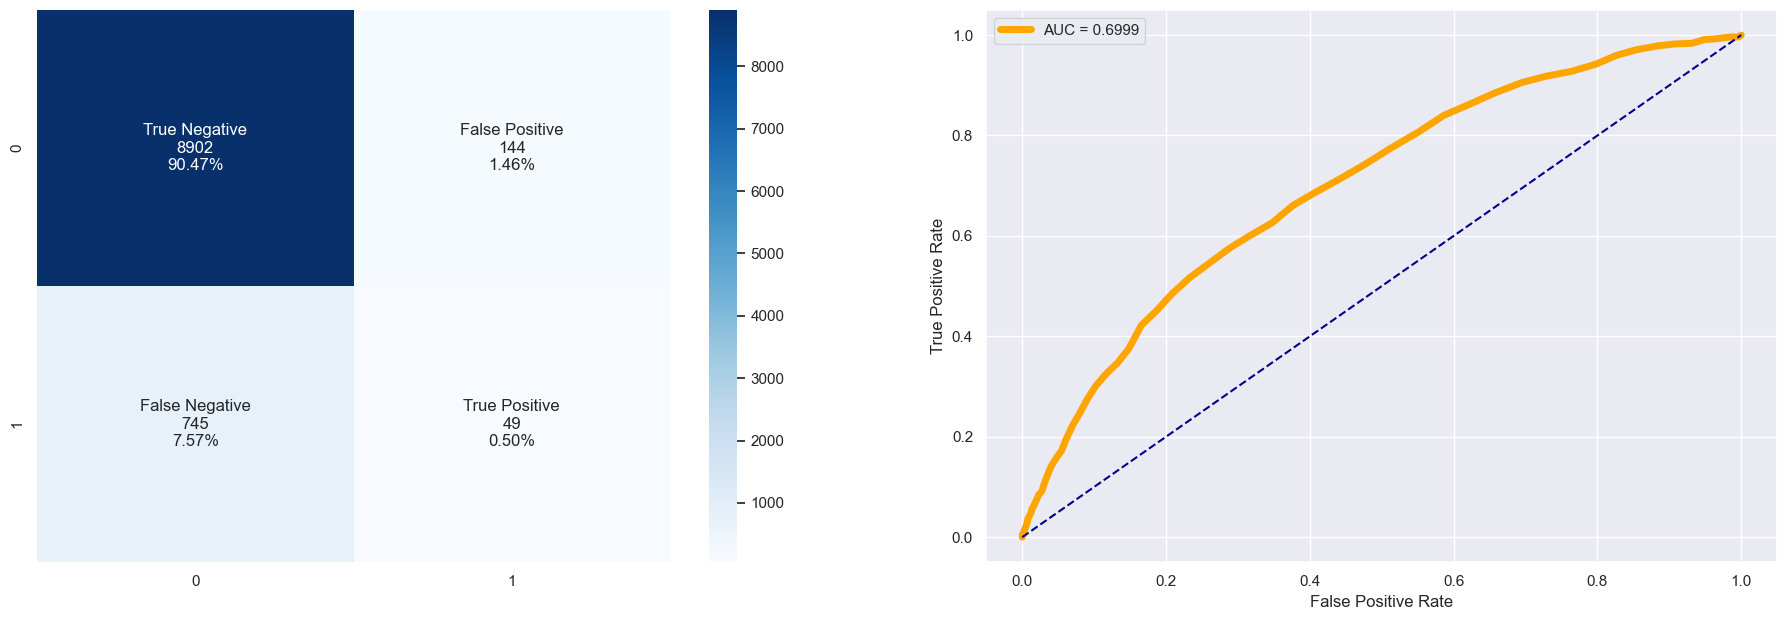

In [42]:
%time
# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_name = 'RandomForest'

# Compute results 
rf_model, rf_results_cv, rf_results_test = train_model(rf_name, rf, cv=5, fast_train=0.2)

##### XGBoost

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

{'fit_time': array([20.94508195, 21.10248113, 20.9203701 , 21.08550715, 20.90208983]), 'score_time': array([0.30300522, 0.27251196, 0.32895398, 0.26948905, 0.31400704]), 'test_accuracy': array([0.89303862, 0.89964431, 0.9007876 , 0.90027947, 0.89850102]), 'test_precision': array([0.23529412, 0.26865672, 0.30376344, 0.3015873 , 0.28608924]), 'test_recall': array([0.14488189, 0.14173228, 0.17795276, 0.17952756, 0.17138365]), 'test_f1': array([0.17933723, 0.18556701, 0.224429  , 0.22507404, 0.21435595]), 'test_roc_auc': array([0.72520131, 0.72086968, 0.751741  , 0.73046919, 0.71686618]), 'test_specificity': array([0.95868454, 0.96614619, 0.96421169, 0.9635208 , 0.96241017]), 'test_fpr': array([-0.04131546, -0.03385381, -0.03578831, -0.0364792 , -0.03758983]), 'test_business_score': array([0.05926986, 0.07158196, 0.10379384, 0.10393701, 0.09362493])}


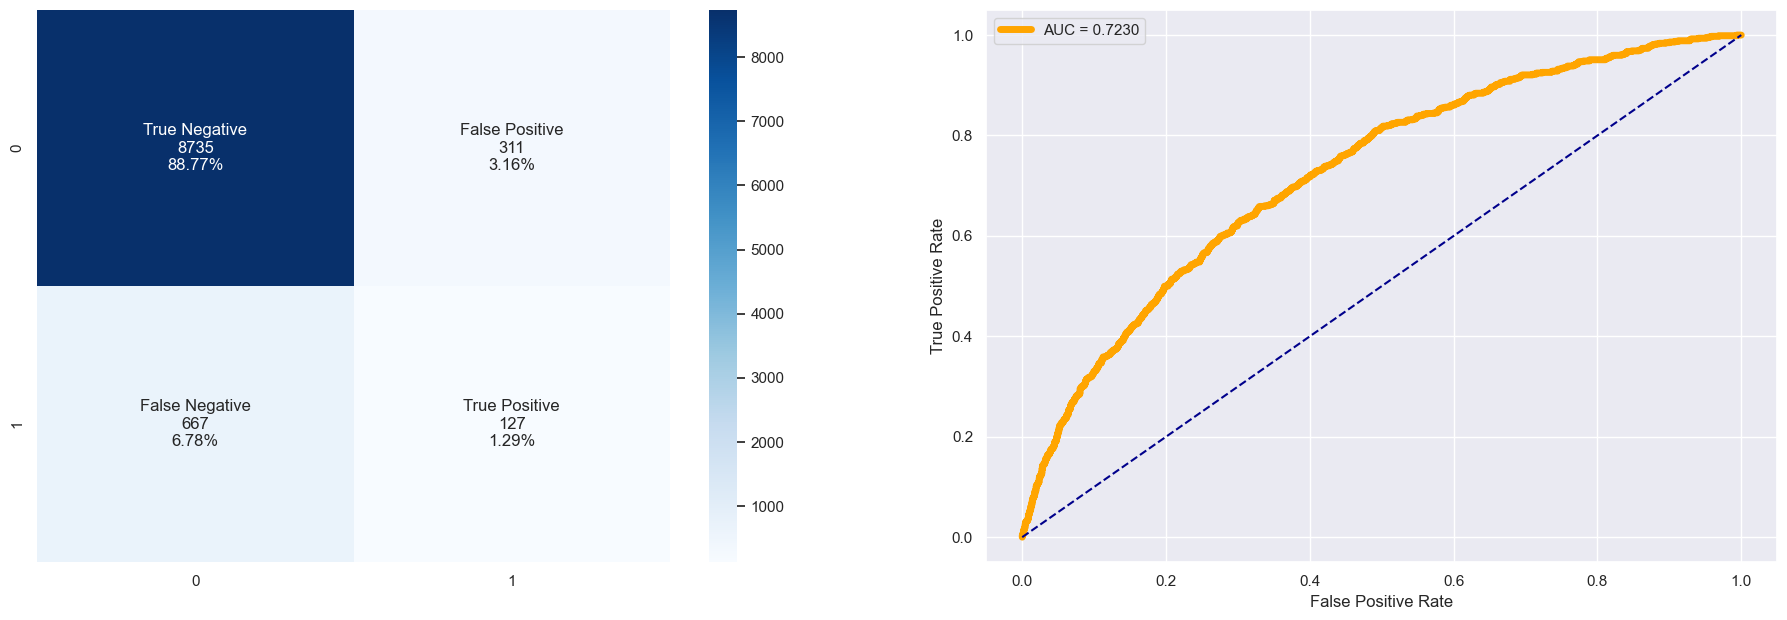

In [43]:
%time
# Create XGBoost classifier
xgbc = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbc_name = 'XGBoost'

# Compute results 
xgbc_model, xgbc_results_cv, xgbc_results_test = train_model(xgbc_name, xgbc, cv=5, fast_train=0.2)

##### LightGBM

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91110
[LightGBM] [Info] Number of data points in the train set: 28946, number of used features: 488
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Number of positive: 14474, number of negative: 14474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91853
[LightGBM] [Info] Number of data points in the train set: 28946, number of used features: 48

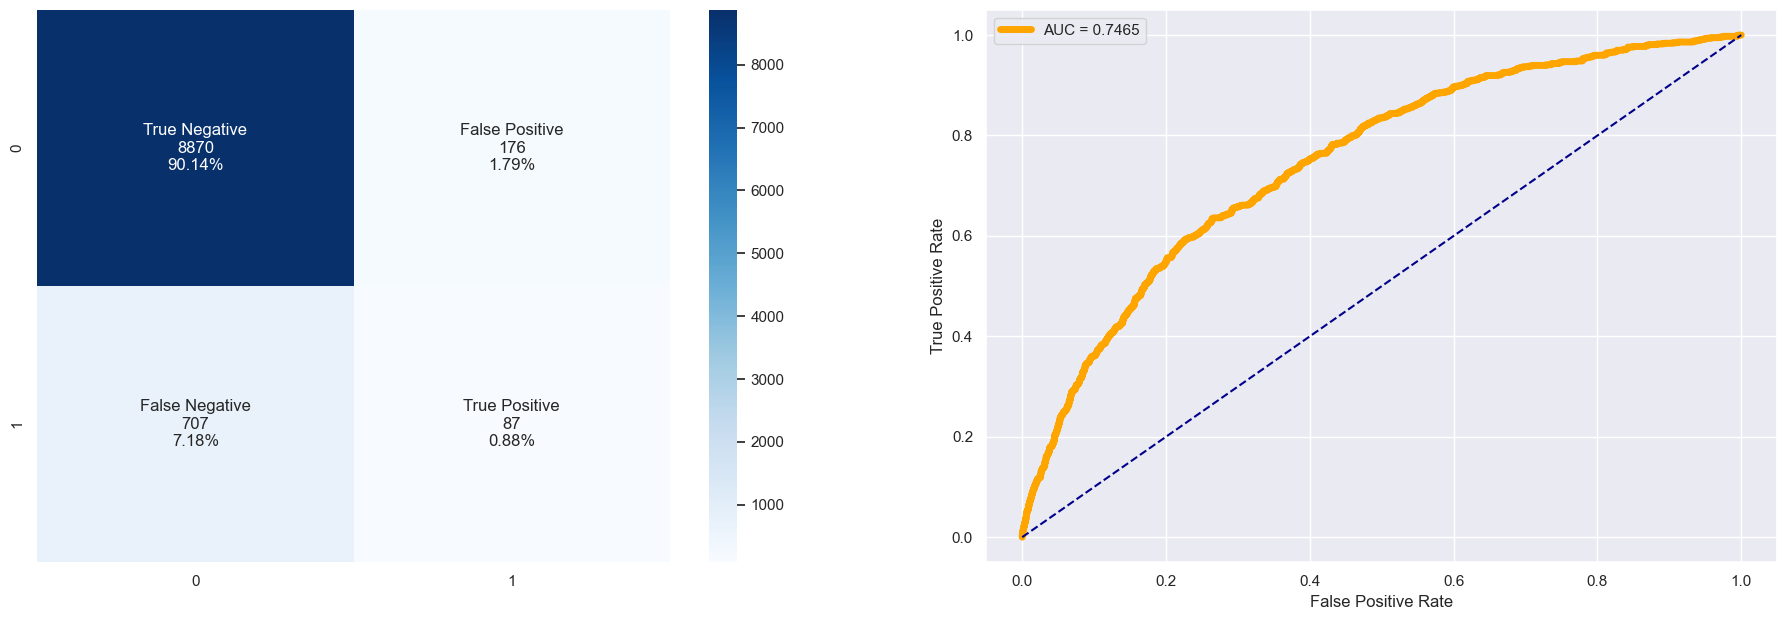

In [44]:
%time
# Create LightGBM classifier
lgbmc = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmc_name = 'LightGBM'

# Compute results 
lgbmc_model, lgbmc_results_cv, lgbmc_results_test = train_model(lgbmc_name, lgbmc, cv=5, fast_train=0.2)

##### CatBoost

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
Learning rate set to 0.043354
Learning rate set to 0.043354
Learning rate set to 0.043354
Learning rate set to 0.043354
0:	learn: 0.6609712	total: 285ms	remaining: 4m 44s
Learning rate set to 0.043356
0:	learn: 0.6615971	total: 360ms	remaining: 6m
0:	learn: 0.6630764	total: 340ms	remaining: 5m 39s
0:	learn: 0.6590339	total: 346ms	remaining: 5m 45s
1:	learn: 0.6320057	total: 457ms	remaining: 3m 47s
1:	learn: 0.6366249	total: 556ms	remaining: 4m 37s
1:	learn: 0.6358854	total: 646ms	remaining: 5m 22s
1:	learn: 0.6298324	total: 608ms	remaining: 5m 3s
0:	learn: 0.6604310	total: 314ms	remaining: 5m 14s
2:	learn: 0.6100802	total: 723ms	remaining: 4m
2:	learn: 0.6096901	total: 756ms	remaining: 4m 11s
1:	learn: 0.6266947	total: 544ms	remaining: 4m 31s
2:	learn: 0.6105656	total: 859ms	remaining: 4m 45s
2:	learn: 0.6120695	total: 919ms	remaining: 5m 5s
3:	learn: 0.5897880	total: 959ms	remaining: 3m 58s
3:	learn: 0.5821101	total: 

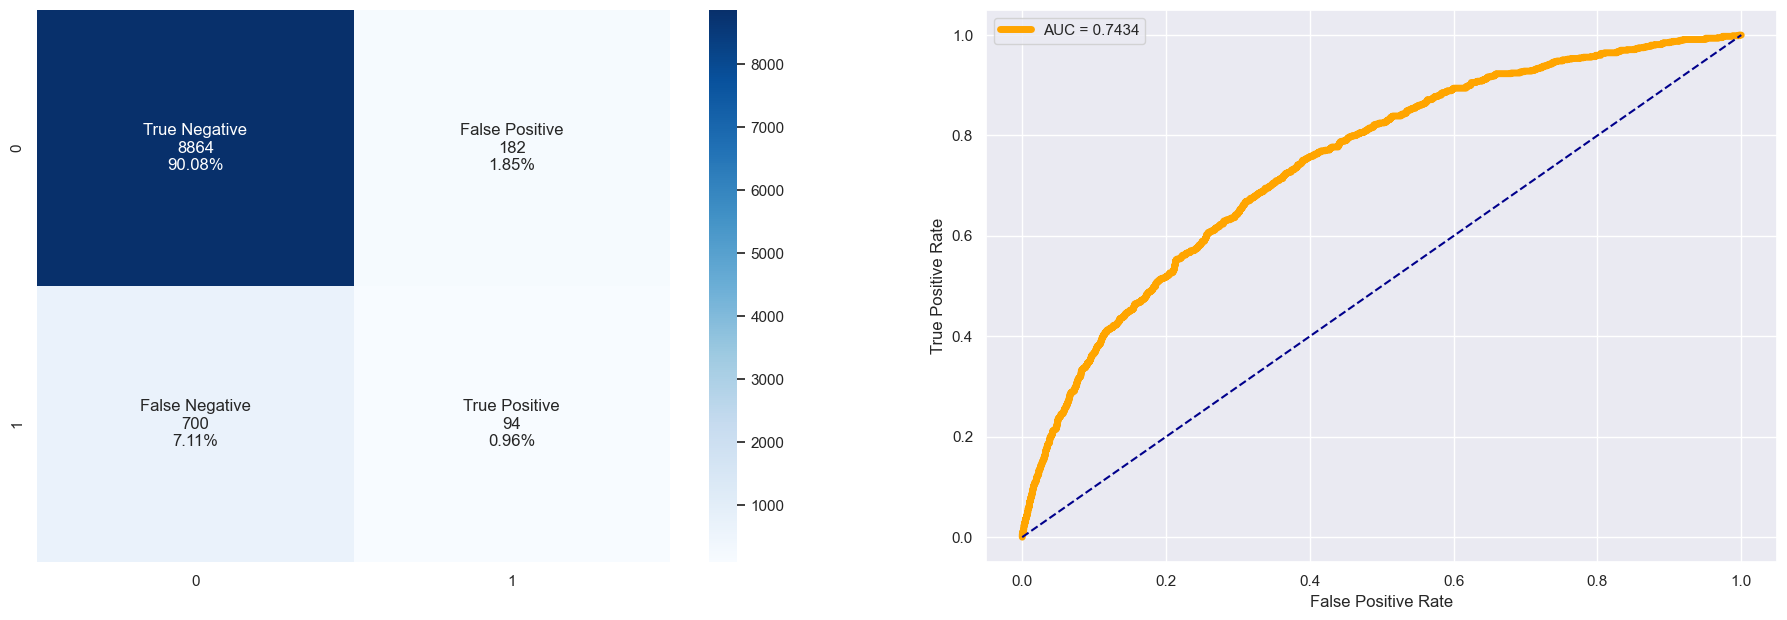

In [45]:
%time
# Create CatBoost classifier
cbc = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbc_name = 'CatBoost'

# Compute results 
cbc_model, cbc_results_cv, cbc_results_test = train_model(cbc_name, cbc, cv=5, fast_train=0.2)

##### Comparison

In [46]:
results_cv = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lr_results_cv, 
    'RandomForest': rf_results_cv,
    'XGBoost': xgbc_results_cv,
    'LightGBM': lgbmc_results_cv,
    'CatBoost': cbc_results_cv
}

pd.DataFrame.from_dict(results_cv)

DummyClassifier  LogisticRegression  RandomForest    XGBoost  \
accuracy               0.491845            0.717022      0.908740   0.898450   
precision              0.077155            0.166565      0.248786   0.279078   
recall                 0.483318            0.626267      0.064543   0.163096   
f1                     0.133068            0.263131      0.102483   0.205753   
roc_auc                0.487956            0.731765      0.706436   0.729029   
specificity            0.492593            0.724989      0.982838   0.962995   
fpr                   -0.507407           -0.275011     -0.017162  -0.037005   
business_score        -0.567746            0.056597      0.028991   0.086442   
fit_time               4.451486           10.001688     36.260172  20.991106   
execution_time         7.520548           13.174328     37.430465  21.707274   

                 LightGBM    CatBoost  
accuracy         0.909807    0.912043  
precision        0.341693    0.372778  
recall           0.125941    0.131610  
f1               0.183845    0.194496  
roc_auc          0.754673    0.757530  
specificity      0.978609    0.980544  
fpr             -0.021391   -0.019456  
business_score   0.081633    0.091308  
fit_time        28.059443  260.888790  
execution_time  29.408285  262.232849

In [47]:
results_test = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lr_results_test, 
    'RandomForest': rf_results_test,
    'XGBoost': xgbc_results_test,
    'LightGBM': lgbmc_results_test,
    'CatBoost': cbc_results_test
}

pd.DataFrame.from_dict(results_test)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
fit_time               1.818802            4.560421     10.797987  6.357956   
accuracy               0.496138            0.712602      0.909654  0.900610   
precision              0.083100            0.155020      0.253886  0.289954   
recall                 0.522670            0.575567      0.061713  0.159950   
f1                     0.143400            0.244254      0.099291  0.206169   
roc_auc                0.508240            0.714450      0.699852  0.722964   
specificity            0.493809            0.724630      0.984081  0.965620   
fpr                    0.506191            0.275370      0.015919  0.034380   
business_score        -0.525876            0.005152      0.028738  0.088734   

                LightGBM   CatBoost  
fit_time        6.036048  56.710626  
accuracy        0.910264   0.910366  
precision       0.330798   0.340580  
recall          0.109572   0.118388  
f1              0.164617   0.175701  
roc_auc         0.746503   0.743435  
specificity     0.980544   0.979881  
fpr             0.019456   0.020119  
business_score  0.069270   0.076712

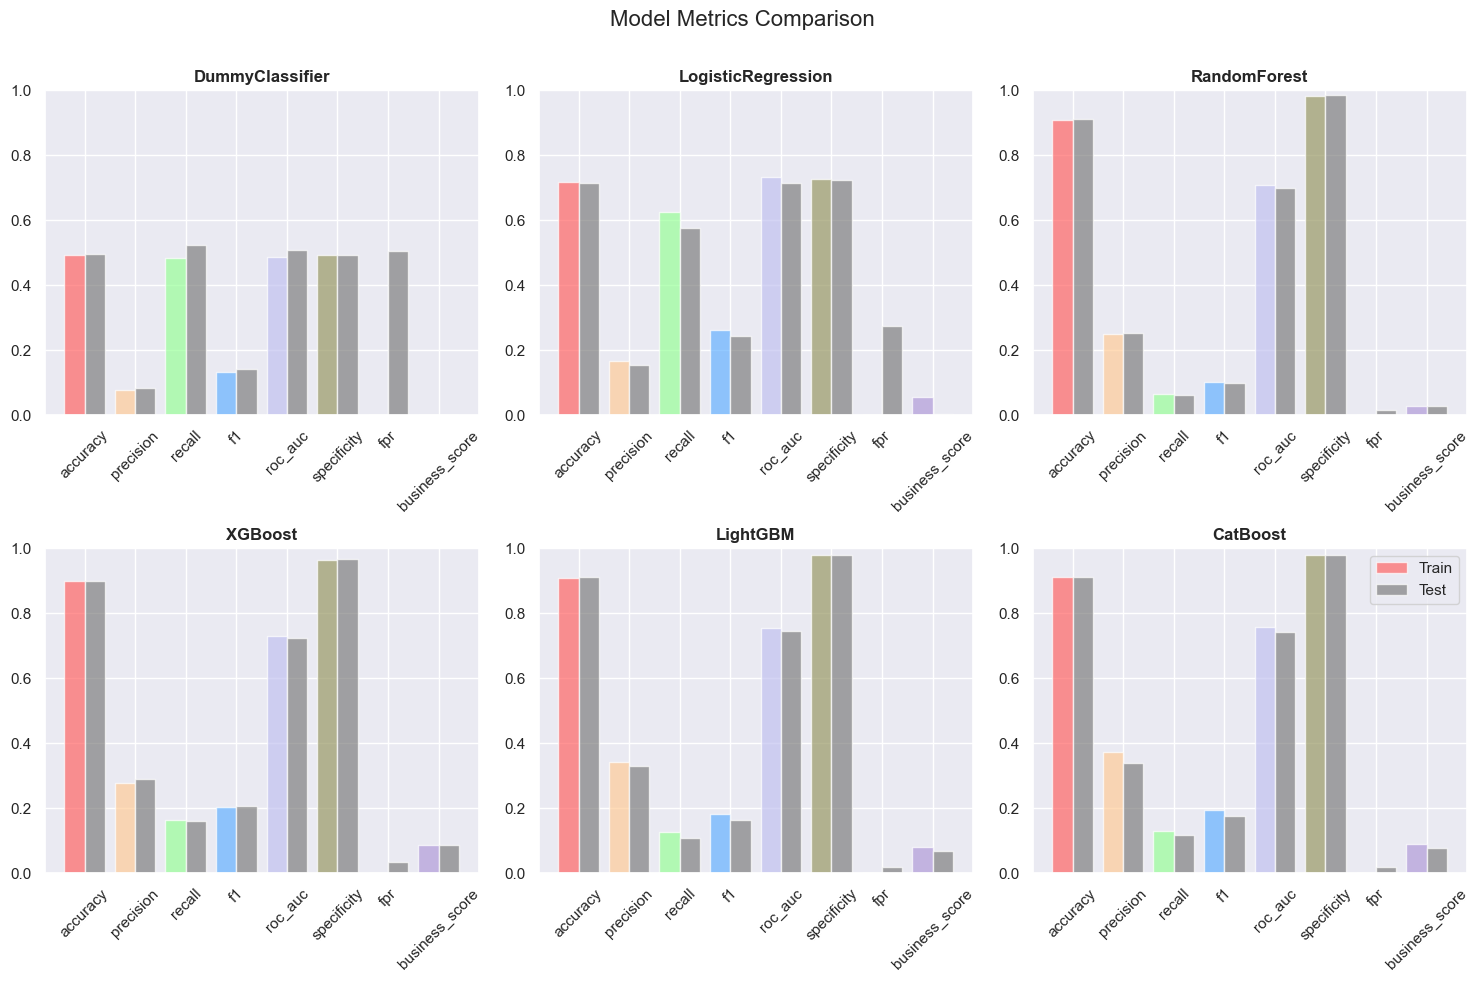

In [48]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv, results_test, metrics)

#### Hyperparameter optimization

For hyperparameter optimization, let's change few things for the sake of computation capacity: 
- Use 20% of total data

##### DummyClassifier (= baseline 0)

Since this one is the baseline 0, it does not need to be optimized.

##### Logistical regression (= baseline 1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will 

[CV 2/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.704) business_score: (test=0.037) f1: (test=0.258) fpr: (test=-0.290) precision: (test=0.162) recall: (test=0.635) roc_auc: (test=0.725) specificity: (test=0.710) total time=  47.0s
[CV 5/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.718) business_score: (test=0.058) f1: (test=0.263) fpr: (test=-0.273) precision: (test=0.167) recall: (test=0.621) roc_auc: (test=0.724) specificity: (test=0.727) total time=  47.0s
[CV 4/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.004) f1: (test=0.246) fpr: (test=-0.289) precision: (test=0.155) recall: (test=0.600) roc_auc: (test=0.720) specificity: (test=0.711) total time=  47.1s
[CV 3/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=non

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.022) f1: (test=0.253) fpr: (test=-0.291) precision: (test=0.158) recall: (test=0.622) roc_auc: (test=0.737) specificity: (test=0.709) total time=  47.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.022) f1: (test=0.253) fpr: (test=-0.291) precision: (test=0.158) recall: (test=0.622) roc_auc: (test=0.737) specificity: (test=0.709) total time=  44.0s
[CV 3/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.039) f1: (test=0.259) fpr: (test=-0.292) precision: (test=0.162) recall: (test=0.641) roc_auc: (test=0.732) specificity: (test=0.708) total time=  43.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.704) business_score: (test=0.037) f1: (test=0.258) fpr: (test=-0.290) precision: (test=0.162) recall: (test=0.635) roc_auc: (test=0.725) specificity: (test=0.710) total time=  44.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 2/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.704) business_score: (test=0.037) f1: (test=0.258) fpr: (test=-0.290) precision: (test=0.162) recall: (test=0.635) roc_auc: (test=0.725) specificity: (test=0.710) total time=  34.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.039) f1: (test=0.259) fpr: (test=-0.292) precision: (test=0.162) recall: (test=0.641) roc_auc: (test=0.732) specificity: (test=0.708) total time=  35.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.022) f1: (test=0.253) fpr: (test=-0.291) precision: (test=0.158) recall: (test=0.622) roc_auc: (test=0.737) specificity: (test=0.709) total time=  36.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.718) business_score: (test=0.058) f1: (test=0.263) fpr: (test=-0.273) precision: (test=0.167) recall: (test=0.621) roc_auc: (test=0.724) specificity: (test=0.727) total time=  36.4s
[CV 4/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.004) f1: (test=0.246) fpr: (test=-0.289) precision: (test=0.155) recall: (test=0.600) roc_auc: (test=0.720) specificity: (test=0.711) total time=  36.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.718) business_score: (test=0.058) f1: (test=0.263) fpr: (test=-0.273) precision: (test=0.167) recall: (test=0.621) roc_auc: (test=0.724) specificity: (test=0.727) total time=  35.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.702) business_score: (test=0.004) f1: (test=0.246) fpr: (test=-0.289) precision: (test=0.155) recall: (test=0.600) roc_auc: (test=0.720) specificity: (test=0.711) total time=  36.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 1/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.712) business_score: (test=0.048) f1: (test=0.261) fpr: (test=-0.280) precision: (test=0.165) recall: (test=0.625) roc_auc: (test=0.739) specificity: (test=0.720) total time=   8.1s
[CV 2/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.709) business_score: (test=0.047) f1: (test=0.261) fpr: (test=-0.284) precision: (test=0.164) recall: (test=0.632) roc_auc: (test=0.732) specificity: (test=0.716) total time=   7.9s
[CV 3/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.711) business_score: (test=0.060) f1: (test=0.265) fpr: (test=-0.283) precision: (test=0.167) recall: (test=0.643) roc_auc: (test=0.734) specificity: (test=0.717) total time=   7.5s
[CV 4/5] END classifier__C=0.001, classifier__max_iter=100, classifier

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.714) business_score: (test=0.034) f1: (test=0.255) fpr: (test=-0.276) precision: (test=0.162) recall: (test=0.603) roc_auc: (test=0.730) specificity: (test=0.724) total time=   7.6s
[CV 4/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.719) business_score: (test=0.032) f1: (test=0.253) fpr: (test=-0.269) precision: (test=0.161) recall: (test=0.586) roc_auc: (test=0.719) specificity: (test=0.731) total time=  16.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.718) business_score: (test=0.054) f1: (test=0.262) fpr: (test=-0.273) precision: (test=0.166) recall: (test=0.616) roc_auc: (test=0.725) specificity: (test=0.727) total time=  18.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.711) business_score: (test=0.038) f1: (test=0.257) fpr: (test=-0.280) precision: (test=0.162) recall: (test=0.616) roc_auc: (test=0.722) specificity: (test=0.720) total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.707) business_score: (test=0.023) f1: (test=0.252) fpr: (test=-0.285) precision: (test=0.159) recall: (test=0.610) roc_auc: (test=0.719) specificity: (test=0.715) total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.719) business_score: (test=0.028) f1: (test=0.252) fpr: (test=-0.269) precision: (test=0.160) recall: (test=0.583) roc_auc: (test=0.719) specificity: (test=0.731) total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  

[CV 5/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.718) business_score: (test=0.053) f1: (test=0.262) fpr: (test=-0.273) precision: (test=0.166) recall: (test=0.616) roc_auc: (test=0.722) specificity: (test=0.727) total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra

[CV 1/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.711) business_score: (test=0.030) f1: (test=0.254) fpr: (test=-0.280) precision: (test=0.161) recall: (test=0.607) roc_auc: (test=0.730) specificity: (test=0.720) total time=  17.9s
[CV 2/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.708) business_score: (test=0.026) f1: (test=0.253) fpr: (test=-0.283) precision: (test=0.160) recall: (test=0.610) roc_auc: (test=0.717) specificity: (test=0.717) total time=  16.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.713) business_score: (test=0.043) f1: (test=0.258) fpr: (test=-0.279) precision: (test=0.163) recall: (test=0.618) roc_auc: (test=0.723) specificity: (test=0.721) total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra

[CV 4/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.718) business_score: (test=0.029) f1: (test=0.252) fpr: (test=-0.271) precision: (test=0.161) recall: (test=0.588) roc_auc: (test=0.720) specificity: (test=0.729) total time=  15.0s
[CV 5/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.717) business_score: (test=0.040) f1: (test=0.257) fpr: (test=-0.273) precision: (test=0.163) recall: (test=0.602) roc_auc: (test=0.723) specificity: (test=0.727) total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 1/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.711) business_score: (test=0.038) f1: (test=0.257) fpr: (test=-0.280) precision: (test=0.162) recall: (test=0.616) roc_auc: (test=0.732) specificity: (test=0.720) total time= 3.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.708) business_score: (test=0.034) f1: (test=0.256) fpr: (test=-0.284) precision: (test=0.161) recall: (test=0.619) roc_auc: (test=0.721) specificity: (test=0.716) total time= 3.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.710) business_score: (test=0.040) f1: (test=0.258) fpr: (test=-0.282) precision: (test=0.163) recall: (test=0.621) roc_auc: (test=0.726) specificity: (test=0.718) total time= 3.1min
[CV 1/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.712) business_score: (test=0.033) f1: (test=0.255) fpr: (test=-0.279) precision: (test=0.161) recall: (test=0.608) roc_auc: (test=0.729) specificity: (test=0.721) total time=  20.0s
[CV 2/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.708) business_score: (test=0.028) f1: (test=0.254) fpr: (test=-0.283) precision: (test=0.160) recall: (test=0.611) roc_auc: (test=0.718) specificity: (test=0.717) total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.713) business_score: (test=0.045) f1: (test=0.259) fpr: (test=-0.279) precision: (test=0.164) recall: (test=0.619) roc_auc: (test=0.731) specificity: (test=0.721) total time= 6.1min
[CV 3/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.711) business_score: (test=0.041) f1: (test=0.258) fpr: (test=-0.281) precision: (test=0.163) recall: (test=0.619) roc_auc: (test=0.723) specificity: (test=0.719) total time=  12.8s
[CV 4/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.718) business_score: (test=0.027) f1: (test=0.251) fpr: (test=-0.270) precision: (test=0.160) recall: (test=0.583) roc_auc: (test=0.720) specificity: (test=0.730) total time=  18.4s
[CV 5/5] END classifier__C=1, classifier__max_iter=500, cla

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.710) business_score: (test=0.042) f1: (test=0.259) fpr: (test=-0.282) precision: (test=0.163) recall: (test=0.624) roc_auc: (test=0.724) specificity: (test=0.718) total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.708) business_score: (test=0.032) f1: (test=0.255) fpr: (test=-0.285) precision: (test=0.161) recall: (test=0.619) roc_auc: (test=0.720) specificity: (test=0.715) total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.715) business_score: (test=0.041) f1: (test=0.258) fpr: (test=-0.276) precision: (test=0.163) recall: (test=0.610) roc_auc: (test=0.721) specificity: (test=0.724) total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.719) business_score: (test=0.025) f1: (test=0.250) fpr: (test=-0.269) precision: (test=0.160) recall: (test=0.580) roc_auc: (test=0.718) specificity: (test=0.731) total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.716) business_score: (test=0.023) f1: (test=0.250) fpr: (test=-0.272) precision: (test=0.159) recall: (test=0.585) roc_auc: (test=0.718) specificity: (test=0.728) total time= 2.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.715) business_score: (test=0.038) f1: (test=0.256) fpr: (test=-0.276) precision: (test=0.163) recall: (test=0.607) roc_auc: (test=0.722) specificity: (test=0.724) total time= 2.2min


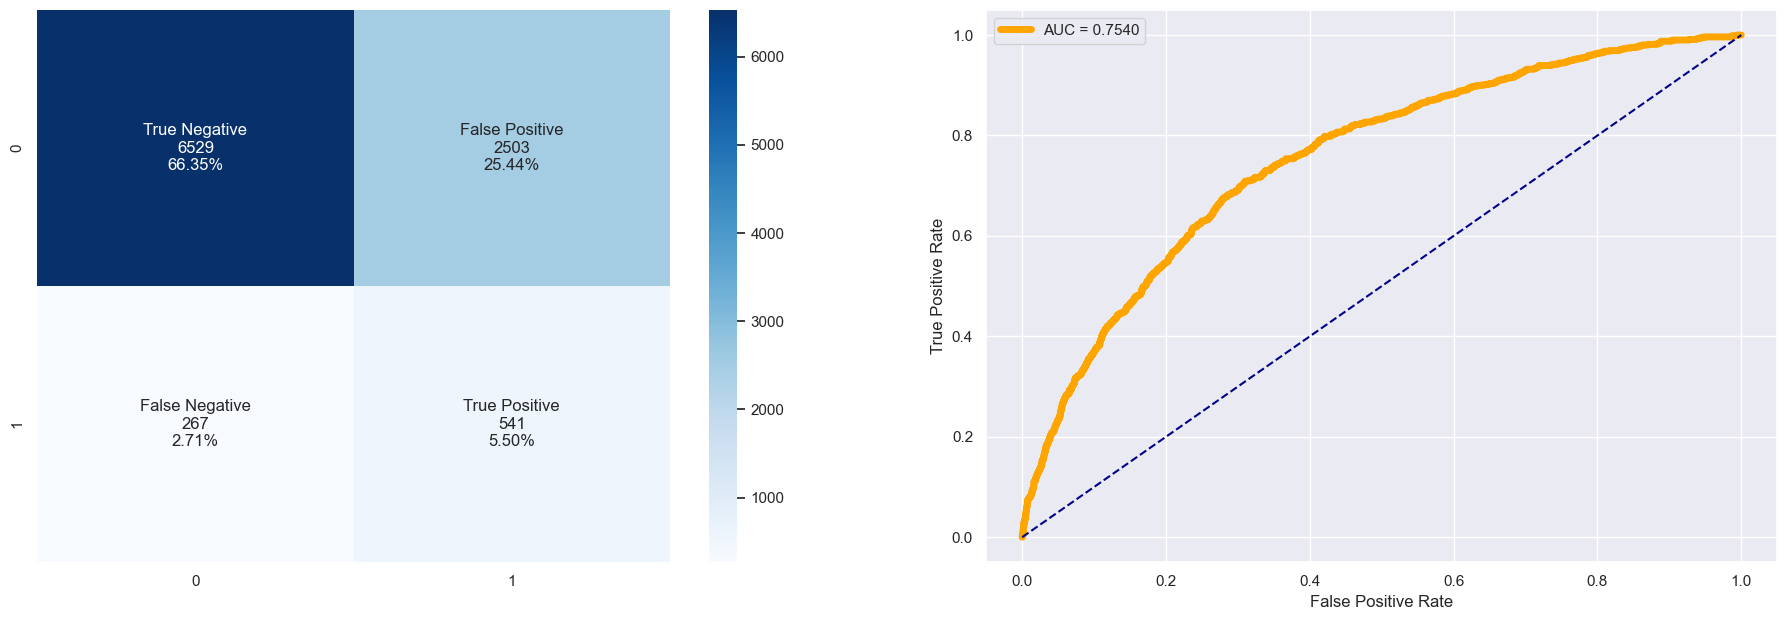

In [49]:
%time
# Create logistic regression model
lrt = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lrt_name = 'LogisticRegression_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l2', 'none'],  # Regularization penalty --> only use l2 due to one-hot encode
    'classifier__solver': ['lbfgs', 'saga', 'newton-cholesky'],  # Solver options
    'classifier__max_iter': [100, 500, 1000],  # Maximum iterations
}

# Compute results and get fine-tuned model
lrt_model, lrt_results_cv, lrt_results_test = search_hyperparameters(lrt_name, lrt, param_grid=param_grid, cv=5, fast_train=0.2)

##### RandomForest

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (test=nan) roc_auc: (test=nan) specificity: (test=nan) total time=   6.0s
[CV 2/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (test=nan) roc_auc: (test=nan) specificity: (test=nan) total time=   6.1s
[CV 1/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (

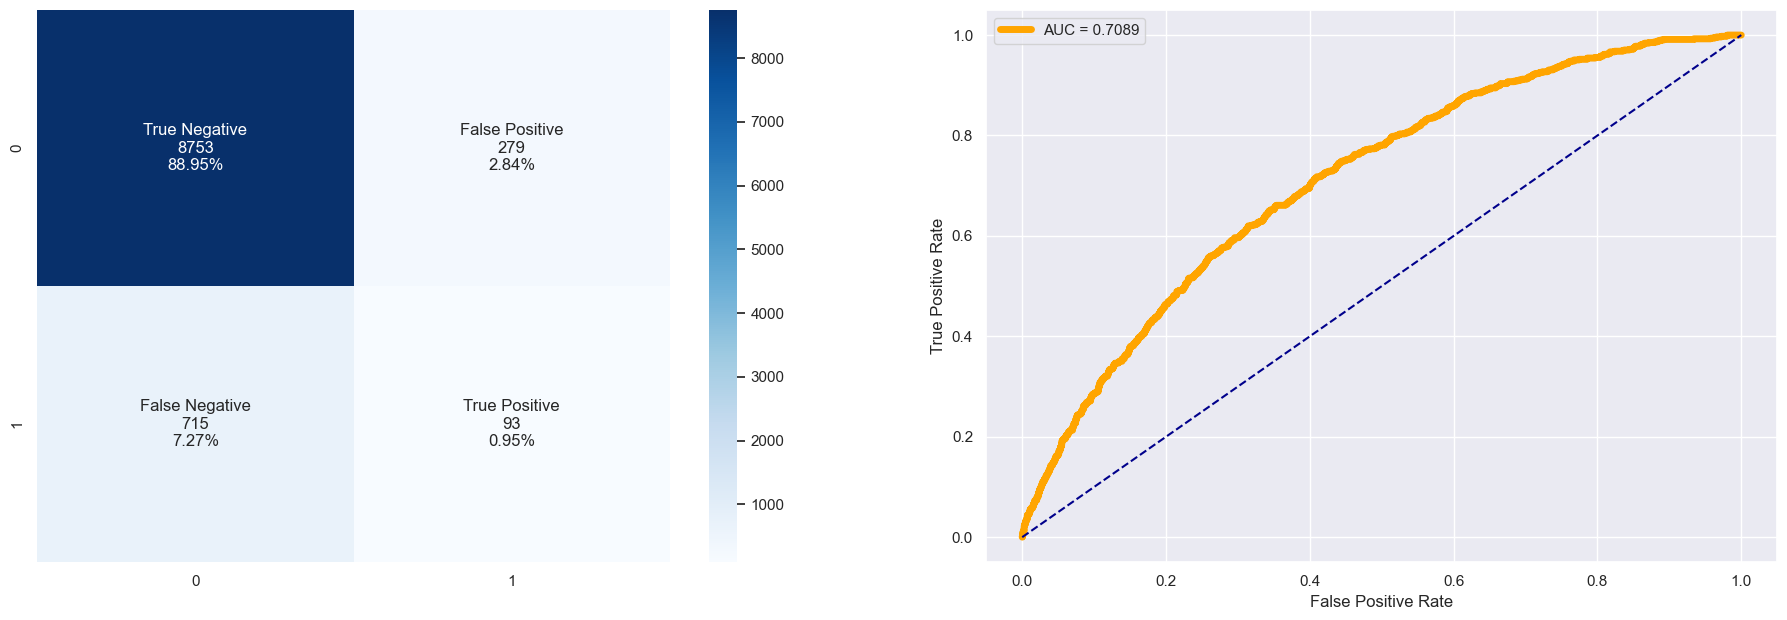

In [50]:
%time
# Create random forest classifier
rft = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rft_name = 'RandomForest_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt'],
}

# Compute results and get fine-tuned model
rft_model, rft_results_cv, rft_results_test = search_hyperparameters(rft_name, rft, param_grid=param_grid, cv=5, fast_train=0.2)

##### XGBoost

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.766) business_score: (test=-0.054) f1: (test=0.197) fpr: (test=-0.198) precision: (test=0.136) recall: (test=0.354) roc_auc: (test=0.657) specificity: (test=0.802) total time=  19.2s
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.786) business_score: (test=-0.028) f1: (test=0.200) fpr: (test=-0.173) precision: (test=0.144) recall: (test=0.329) roc_auc: (test=0.653) specificity: (test=0.827) total time=  19.7s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.770) business_score: (test=-0.043) f1: (test=0.201) fpr: (test=-0.194) precision: (test=0.140) recall: (test=0.357) roc_auc: (test=0.653) specificity: (test=0.806) total time=  20.0s
[CV 5/5] END classi

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.797) business_score: (test=-0.025) f1: (test=0.195) fpr: (test=-0.159) precision: (test=0.144) recall: (test=0.304) roc_auc: (test=0.651) specificity: (test=0.841) total time=  18.1s
[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.809) business_score: (test=0.039) f1: (test=0.228) fpr: (test=-0.150) precision: (test=0.170) recall: (test=0.348) roc_auc: (test=0.669) specificity: (test=0.850) total time=  17.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.910) business_score: (test=0.058) f1: (test=0.147) fpr: (test=-0.018) precision: (test=0.314) recall: (test=0.096) roc_auc: (test=0.731) specificity: (test=0.982) total time=  24.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.910) business_score: (test=0.083) f1: (test=0.185) fpr: (test=-0.021) precision: (test=0.343) recall: (test=0.127) roc_auc: (test=0.743) specificity: (test=0.979) total time=  23.3s
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.910) business_score: (test=0.050) f1: (test=0.134) fpr: (test=-0.018) precision: (test=0.301) recall: (test=0.086) roc_auc: (test=0.735) specificity: (test=0.982) total time=  24.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:05:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:05:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.907) business_score: (test=0.050) f1: (test=0.141) fpr: (test=-0.021) precision: (test=0.280) recall: (test=0.094) roc_auc: (test=0.716) specificity: (test=0.979) total time=  20.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:05:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.912) business_score: (test=0.083) f1: (test=0.181) fpr: (test=-0.018) precision: (test=0.374) recall: (test=0.119) roc_auc: (test=0.727) specificity: (test=0.982) total time=  24.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:05:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.902) business_score: (test=0.053) f1: (test=0.155) fpr: (test=-0.028) precision: (test=0.256) recall: (test=0.111) roc_auc: (test=0.716) specificity: (test=0.972) total time= 1.6min
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.895) business_score: (test=0.053) f1: (test=0.168) fpr: (test=-0.037) precision: (test=0.235) recall: (test=0.130) roc_auc: (test=0.703) specificity: (test=0.963) total time=  56.7s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.893) business_score: (test=0.059) f1: (test=0.178) fpr: (test=-0.041) precision: (test=0.237) recall: (test=0.143) roc_auc: (test=0.705) specificity: (test=0.959) total time= 1.6min
[CV 5/5] END classif

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.896) business_score: (test=0.041) f1: (test=0.150) fpr: (test=-0.035) precision: (test=0.222) recall: (test=0.113) roc_auc: (test=0.695) specificity: (test=0.965) total time= 1.7min
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.887) business_score: (test=0.053) f1: (test=0.179) fpr: (test=-0.048) precision: (test=0.218) recall: (test=0.152) roc_auc: (test=0.697) specificity: (test=0.952) total time=  58.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.901) business_score: (test=0.083) f1: (test=0.198) fpr: (test=-0.033) precision: (test=0.288) recall: (test=0.150) roc_auc: (test=0.711) specificity: (test=0.967) total time=  16.6s
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.901) business_score: (test=0.076) f1: (test=0.188) fpr: (test=-0.032) precision: (test=0.281) recall: (test=0.141) roc_auc: (test=0.720) specificity: (test=0.968) total time=  16.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.898) business_score: (test=0.065) f1: (test=0.178) fpr: (test=-0.035) precision: (test=0.257) recall: (test=0.136) roc_auc: (test=0.707) specificity: (test=0.965) total time=  16.6s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.888) business_score: (test=0.050) f1: (test=0.175) fpr: (test=-0.047) precision: (test=0.216) recall: (test=0.147) roc_auc: (test=0.706) specificity: (test=0.953) total time=  56.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.894) business_score: (test=0.034) f1: (test=0.145) fpr: (test=-0.037) precision: (test=0.208) recall: (test=0.111) roc_auc: (test=0.694) specificity: (test=0.963) total time=  18.9s
[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.903) business_score: (test=0.070) f1: (test=0.178) fpr: (test=-0.029) precision: (test=0.282) recall: (test=0.130) roc_auc: (test=0.709) specificity: (test=0.971) total time=  19.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.857) business_score: (test=0.033) f1: (test=0.193) fpr: (test=-0.086) precision: (test=0.178) recall: (test=0.212) roc_auc: (test=0.683) specificity: (test=0.914) total time=  28.9s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.851) business_score: (test=0.033) f1: (test=0.198) fpr: (test=-0.093) precision: (test=0.176) recall: (test=0.226) roc_auc: (test=0.683) specificity: (test=0.907) total time=  29.0s
[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.887) business_score: (test=0.027) f1: (test=0.148) fpr: (test=-0.045) precision: (test=0.190) recall: (test=0.121) roc_auc: (test=0.683) specificity: (test=0.955) total time=  54.5s
[CV 3/5] END classifie

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.869) business_score: (test=0.068) f1: (test=0.214) fpr: (test=-0.074) precision: (test=0.208) recall: (test=0.219) roc_auc: (test=0.692) specificity: (test=0.926) total time=  29.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:06:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.826) business_score: (test=0.031) f1: (test=0.214) fpr: (test=-0.126) precision: (test=0.169) recall: (test=0.292) roc_auc: (test=0.675) specificity: (test=0.874) total time=  24.1s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.823) business_score: (test=0.032) f1: (test=0.216) fpr: (test=-0.130) precision: (test=0.169) recall: (test=0.301) roc_auc: (test=0.680) specificity: (test=0.870) total time=  22.4s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.837) business_score: (test=0.019) f1: (test=0.198) fpr: (test=-0.112) precision: (test=0.165) recall: (test=0.249) roc_auc: (test=0.673) specificity: (test=0.888) total time=  22.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:07:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:07:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:07:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.898) business_score: (test=0.086) f1: (test=0.205) fpr: (test=-0.037) precision: (test=0.280) recall: (test=0.161) roc_auc: (test=0.718) specificity: (test=0.963) total time=  59.8s
[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.819) business_score: (test=-0.005) f1: (test=0.194) fpr: (test=-0.132) precision: (test=0.152) recall: (test=0.268) roc_auc: (test=0.663) specificity: (test=0.868) total time=  25.0s
[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.836) business_score: (test=0.080) f1: (test=0.243) fpr: (test=-0.119) precision: (test=0.194) recall: (test=0.326) roc_auc: (test=0.679) specificity: (test=0.881) total time=  25.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:07:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.901) business_score: (test=0.096) f1: (test=0.215) fpr: (test=-0.035) precision: (test=0.298) recall: (test=0.168) roc_auc: (test=0.728) specificity: (test=0.965) total time= 1.0min
[CV 3/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.903) business_score: (test=0.087) f1: (test=0.201) fpr: (test=-0.031) precision: (test=0.303) recall: (test=0.150) roc_auc: (test=0.730) specificity: (test=0.969) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:07:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.900) business_score: (test=0.067) f1: (test=0.178) fpr: (test=-0.032) precision: (test=0.268) recall: (test=0.133) roc_auc: (test=0.715) specificity: (test=0.968) total time= 1.0min
[CV 5/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.899) business_score: (test=0.071) f1: (test=0.185) fpr: (test=-0.034) precision: (test=0.267) recall: (test=0.141) roc_auc: (test=0.713) specificity: (test=0.966) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:07:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:07:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.884) business_score: (test=0.065) f1: (test=0.198) fpr: (test=-0.054) precision: (test=0.224) recall: (test=0.177) roc_auc: (test=0.698) specificity: (test=0.946) total time=  40.5s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.871) business_score: (test=0.047) f1: (test=0.192) fpr: (test=-0.068) precision: (test=0.195) recall: (test=0.188) roc_auc: (test=0.697) specificity: (test=0.932) total time=  39.1s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.879) business_score: (test=0.046) f1: (test=0.182) fpr: (test=-0.058) precision: (test=0.201) recall: (test=0.166) roc_auc: (test=0.695) specificity: (test=0.942) total time=  32.9s
[CV 4/5] END classi

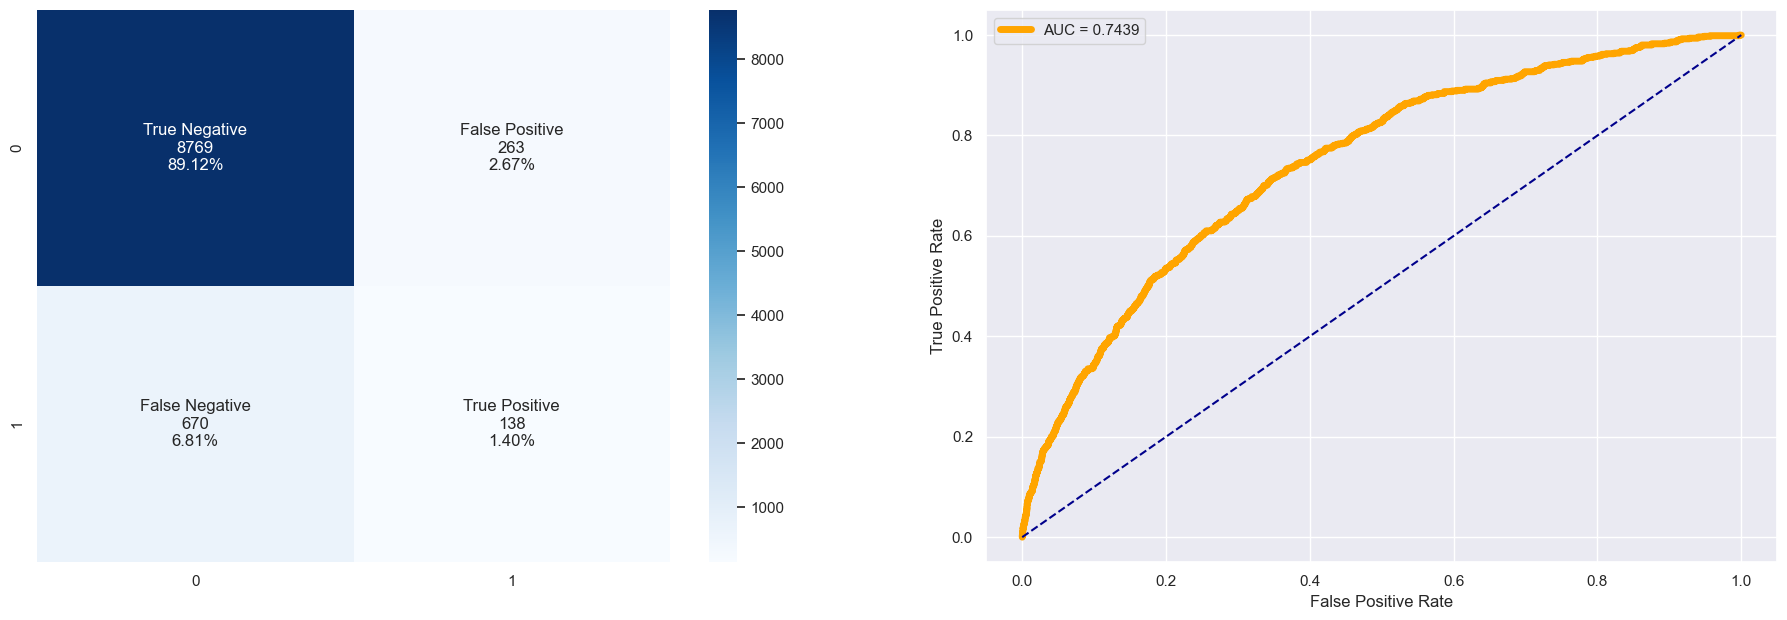

In [51]:
%time
# Create XGBoost classifier
xgbct = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbct_name = 'XGBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
xgbct_model, xgbct_results_cv, xgbct_results_test = search_hyperparameters(xgbct_name, xgbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### LightGBM

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91787
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 487
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

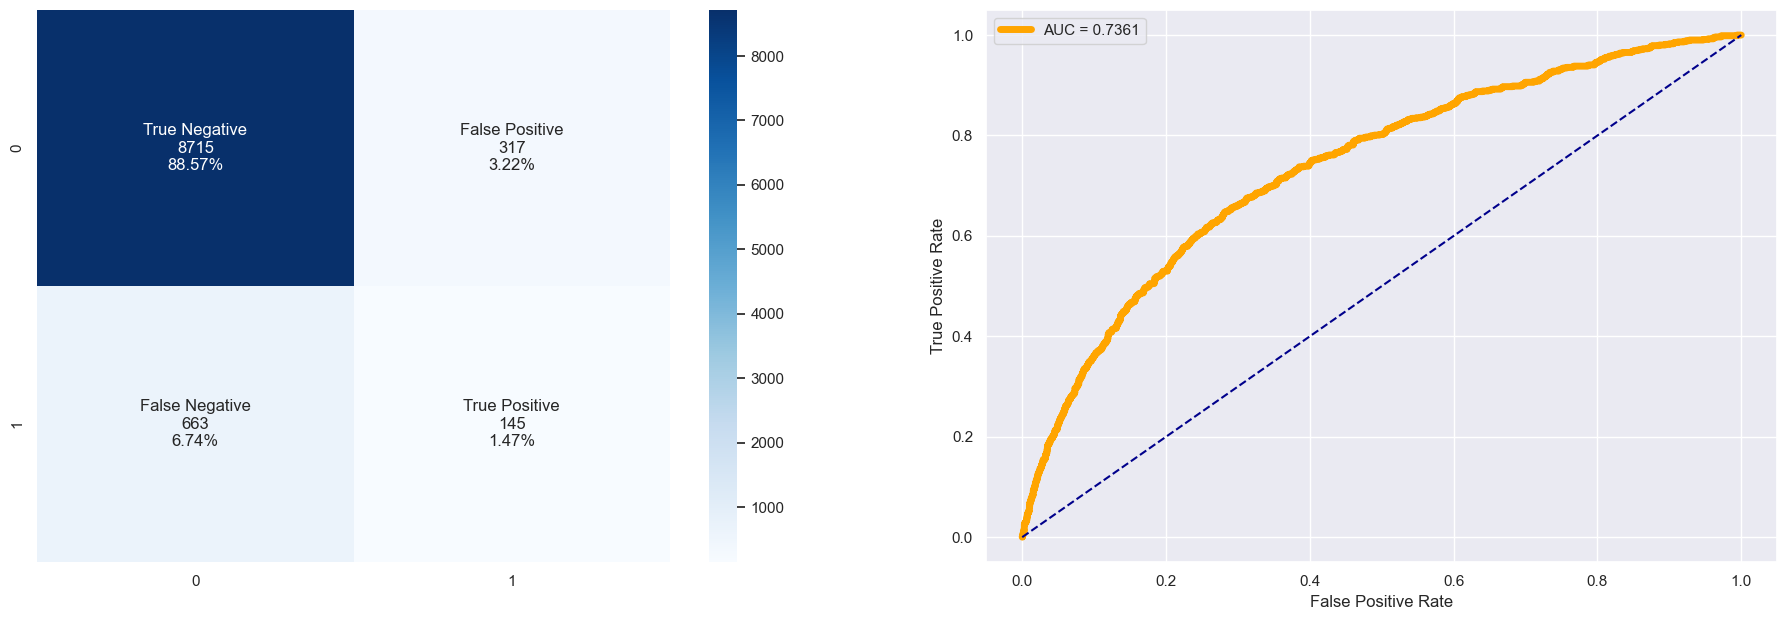

In [52]:
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3 , 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2)

##### CatBoost

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6853405	total: 547ms	remaining: 26.8s
0:	learn: 0.6066645	total: 861ms	remaining: 42.2s
0:	learn: 0.6829342	total: 629ms	remaining: 30.8s
0:	learn: 0.5976248	total: 1.1s	remaining: 53.9s
1:	learn: 0.6771685	total: 1.12s	remaining: 26.9s
0:	learn: 0.5973728	total: 1.08s	remaining: 53.2s
1:	learn: 0.6757416	total: 1.29s	remaining: 30.9s
2:	learn: 0.6690399	total: 1.67s	remaining: 26.1s
1:	learn: 0.5379086	total: 1.97s	remaining: 47.2s
2:	learn: 0.6688460	total: 1.84s	remaining: 28.8s
1:	learn: 0.5425354	total: 2.16s	remaining: 51.8s
3:	learn: 0.6598523	total: 2.17s	remaining: 24.9s
1:	learn: 0.5344026	total: 2.07s	remaining: 49.7s
3:	learn: 0.6622376	total: 2.45s	remaining: 28.2s
2:	learn: 0.4990813	total: 2.91s	remaining: 45.6s
4:	learn: 0.6519849	total: 2.73s	remaining: 24.6s
0:	learn: 0.6083770	total: 1.35s	remaining: 1m 5s
5:	learn: 0.6436528	to

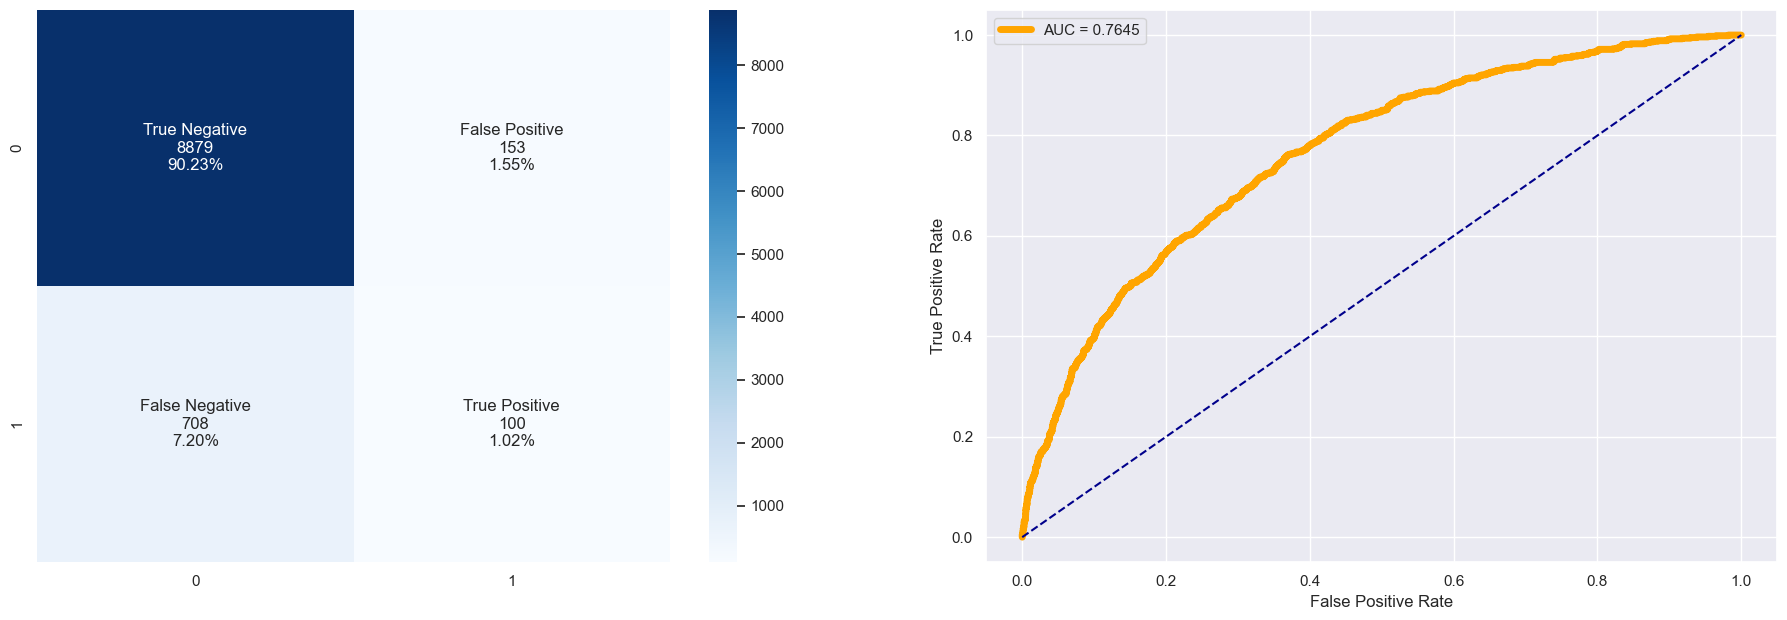

In [53]:
%time
# Create CatBoost classifier
cbct = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbct_name = 'CatBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__iterations': [50, 100, 200],
    'classifier__depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0],  
}

# Compute results and get fine-tuned model
cbct_model, cbct_results_cv, cbct_results_test = search_hyperparameters(cbct_name, cbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### Comparison

In [55]:
results_cv_tuned = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lrt_results_cv, 
    'RandomForest': rft_results_cv,
    'XGBoost': xgbct_results_cv,
    'LightGBM': lgbmct_results_cv,
    'CatBoost': cbct_results_cv
}

pd.DataFrame.from_dict(results_cv_tuned)

DummyClassifier  LogisticRegression  RandomForest     XGBoost  \
accuracy               0.491845            0.712398      0.901296    0.900254   
precision              0.077155            0.164487      0.260636    0.283196   
recall                 0.483318            0.624765      0.118495    0.150784   
f1                     0.133068            0.260407      0.162889    0.196618   
roc_auc                0.487956            0.731450      0.695411    0.720805   
specificity            0.492593            0.720127      0.970335    0.966353   
fpr                   -0.507407           -0.279873     -0.029665   -0.033647   
business_score        -0.567746            0.047791      0.057338    0.081419   
fit_time               4.451486                 NaN           NaN         NaN   
execution_time         7.520548                 NaN           NaN         NaN   
search_time                 NaN          492.303104    205.105557  267.548312   

                  LightGBM    CatBoost  
accuracy          0.899187    0.912754  
precision         0.287745    0.379794  
recall            0.164890    0.119122  
f1                0.209433    0.180885  
roc_auc           0.717901    0.748980  
specificity       0.963948    0.982748  
fpr              -0.036052   -0.017252  
business_score    0.090567    0.083557  
fit_time               NaN         NaN  
execution_time         NaN         NaN  
search_time     160.633510  615.567299

In [56]:
results_test_tuned = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lrt_results_test, 
    'RandomForest': rft_results_test,
    'XGBoost': xgbct_results_test,
    'LightGBM': lgbmct_results_test,
    'CatBoost': cbct_results_test
}

pd.DataFrame.from_dict(results_test_tuned)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
fit_time               1.818802                 NaN           NaN       NaN   
accuracy               0.496138            0.718496      0.898984  0.905183   
precision              0.083100            0.177727      0.250000  0.344140   
recall                 0.522670            0.669554      0.115099  0.170792   
f1                     0.143400            0.280893      0.157627  0.228288   
roc_auc                0.508240            0.754011      0.708912  0.743933   
specificity            0.493809            0.722874      0.969110  0.970881   
fpr                    0.506191            0.277126      0.030890  0.029119   
business_score        -0.525876            0.106323      0.052318  0.111611   

                LightGBM  CatBoost  
fit_time             NaN       NaN  
accuracy        0.900407  0.912500  
precision       0.313853  0.395257  
recall          0.179455  0.123762  
f1              0.228346  0.188501  
roc_auc         0.736120  0.764465  
specificity     0.964903  0.983060  
fpr             0.035097  0.016940  
business_score  0.108123  0.089334

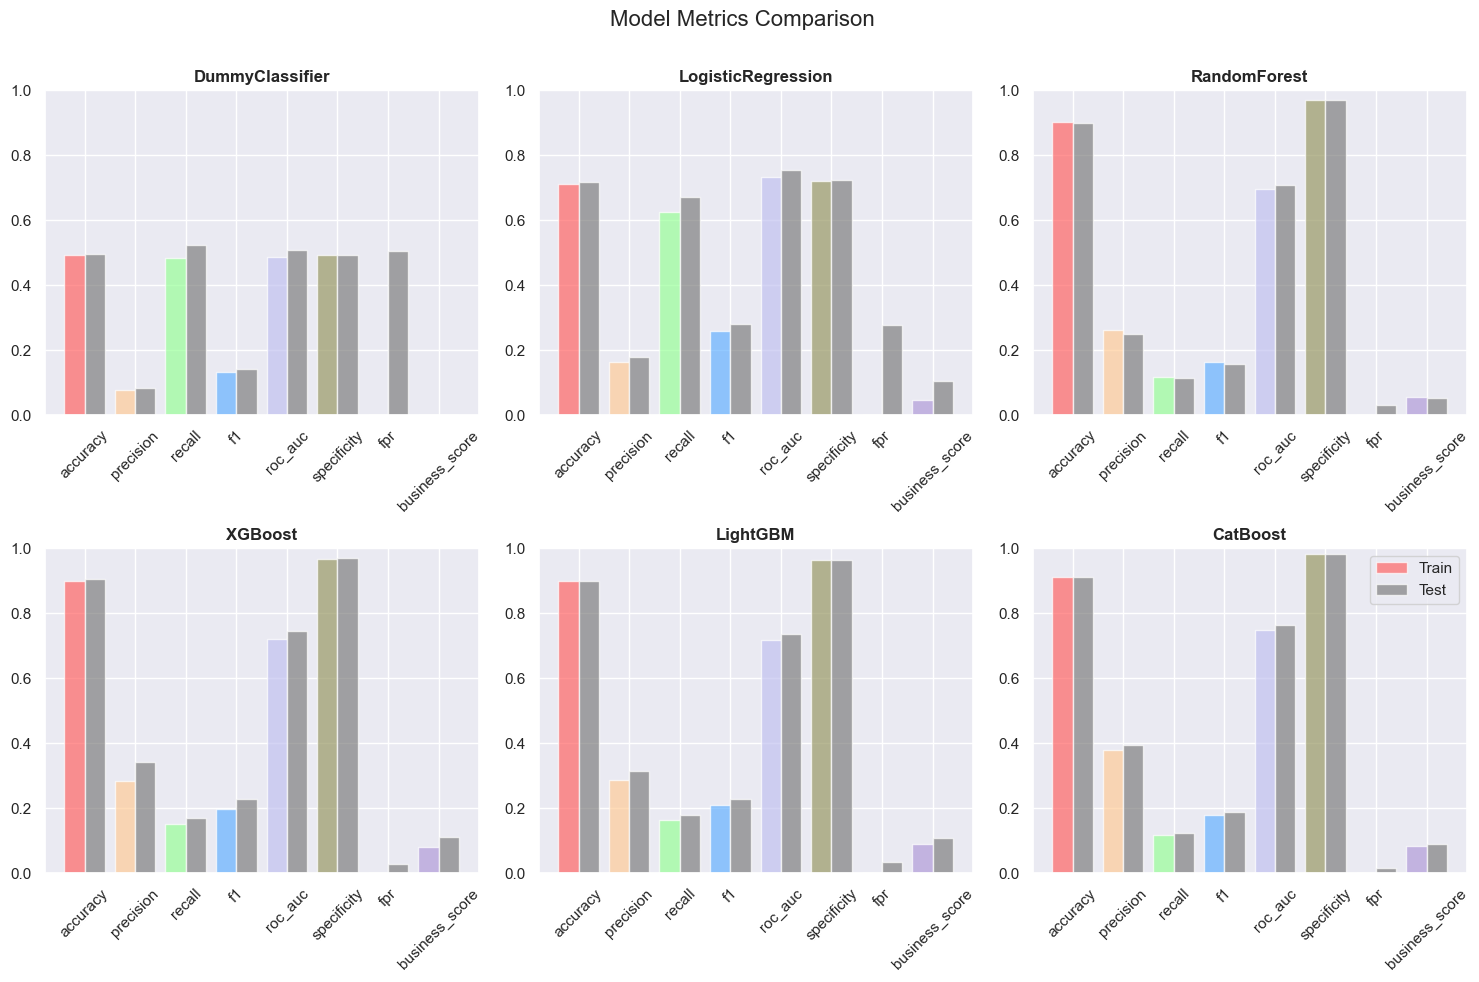

In [57]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv_tuned, results_test_tuned, metrics)

In [58]:
# Comparison between model before and after fine tuning

def plot_metrics_dual_per_model(model_name, train_results, test_results, train_results_ft, test_results_ft):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
    
    # Define colors
    colors = {'Val': 'darkblue', 'Test': 'darkorange', 'Val-FT': 'darkblue', 'Test-FT': 'darkorange'}

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # Add a super title with the model's name
    fig.suptitle(model_name, fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i // 4, i % 4]
        data = [
            train_results.get(metric, 0),
            test_results.get(metric, 0),
            train_results_ft.get(metric, 0),
            test_results_ft.get(metric, 0),
        ]
        x_labels = ['Val', 'Test', 'Val-FT', 'Test-FT']

        ax.bar(x_labels, data, color=[colors[label] for label in x_labels])
        ax.set_ylabel(metric)
        ax.set_title(metric)

        # Rotate x-axis labels
        ax.set_xticklabels(x_labels, rotation=45)

        # Set y-axis limits to vary from 0 to 1
        ax.set_ylim(0, 1)

    plt.tight_layout()  # Set the layout tight
    plt.show()

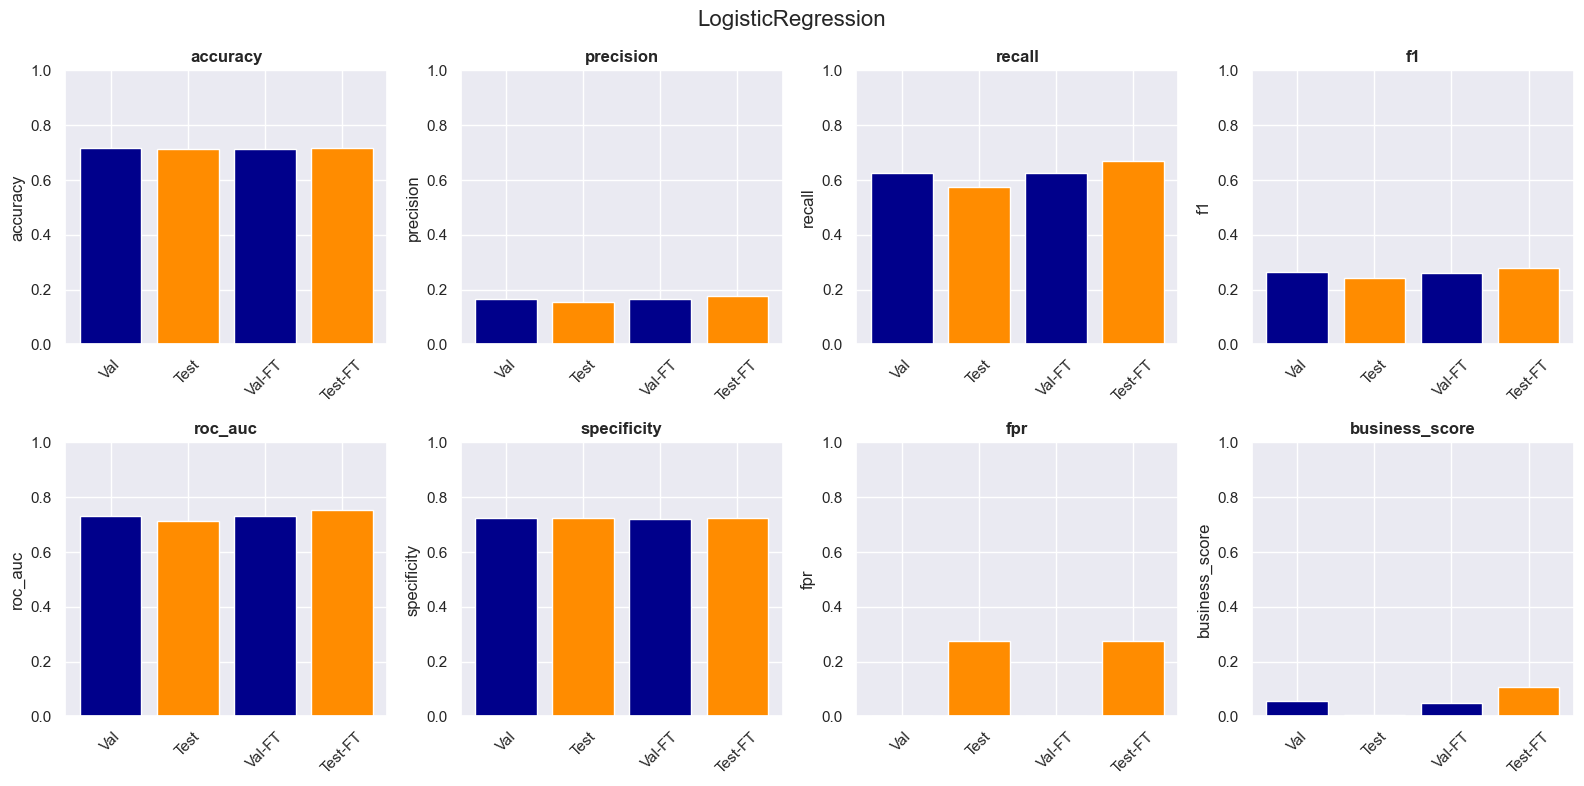

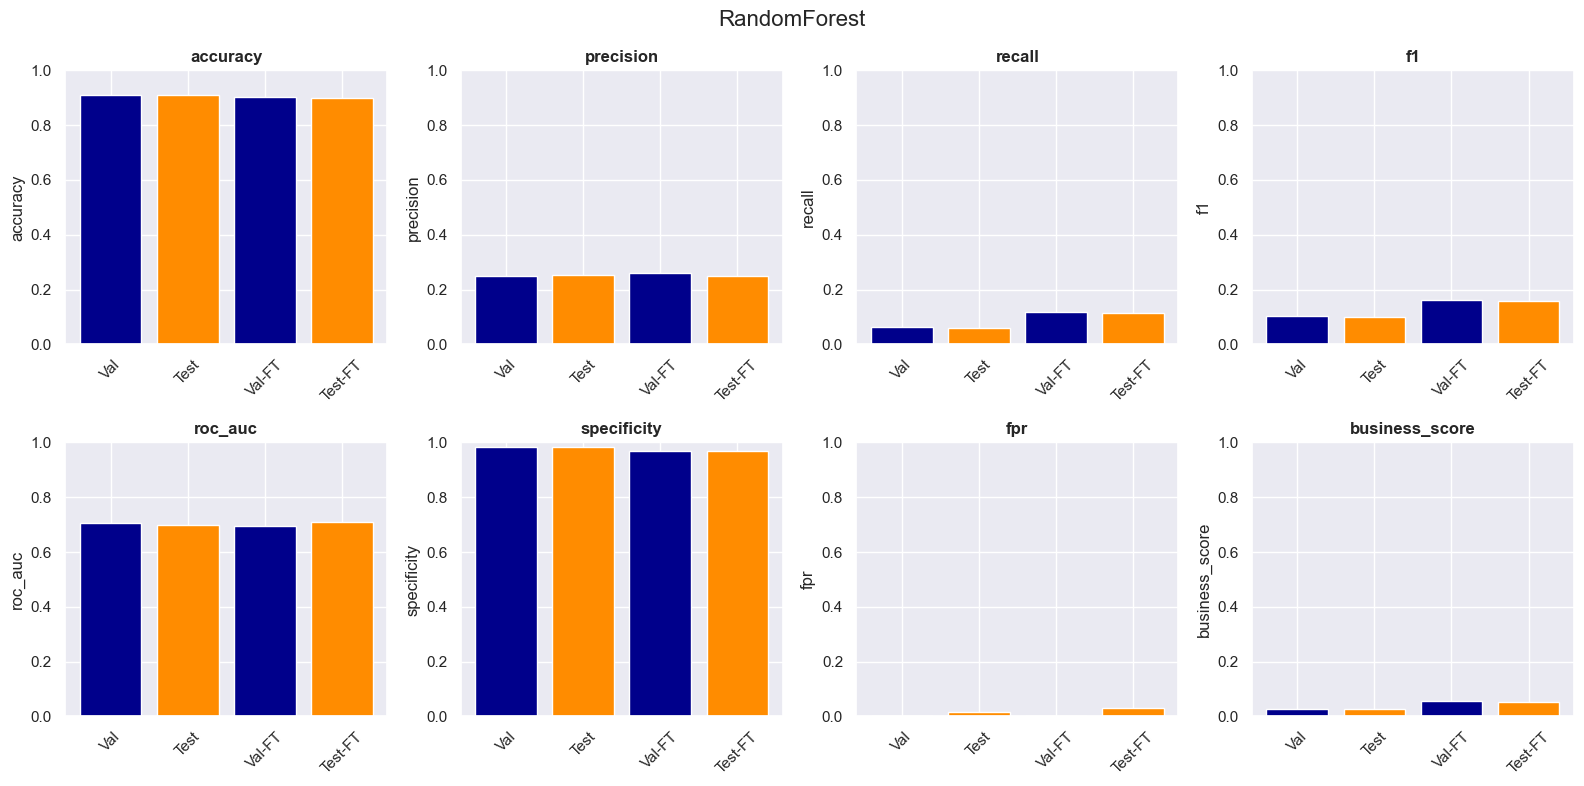

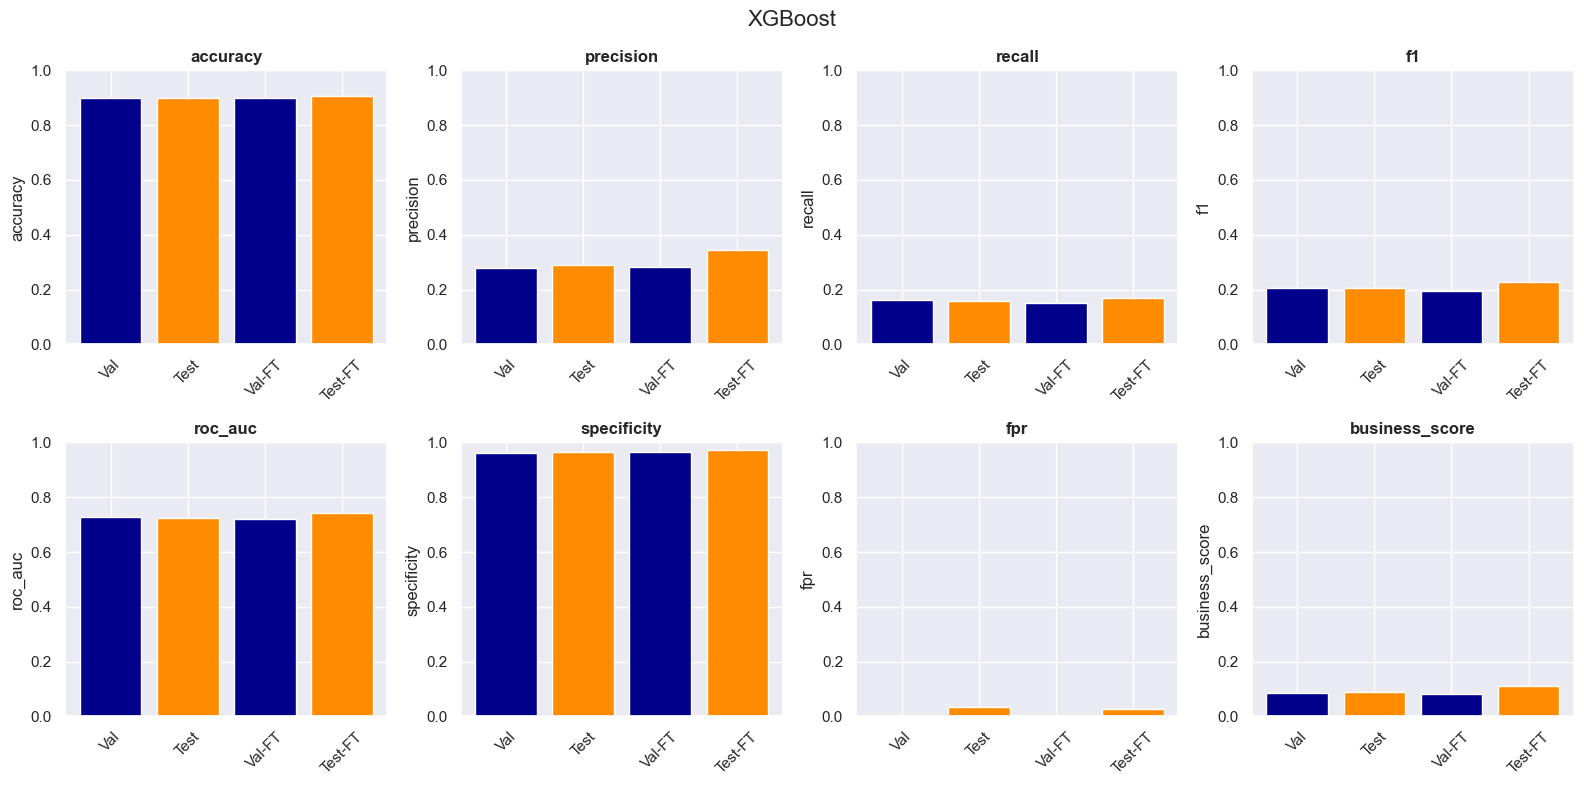

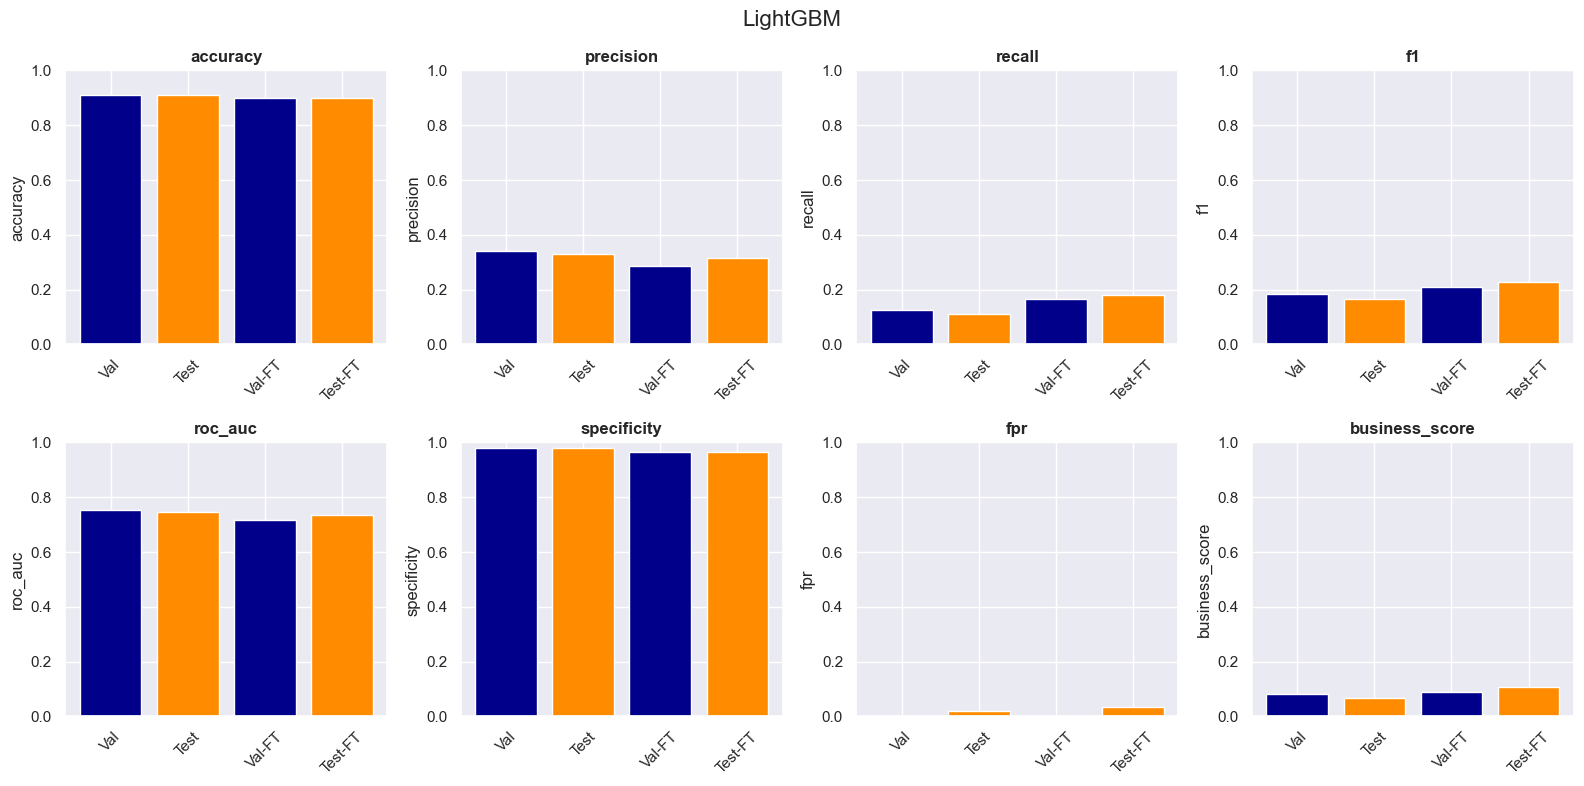

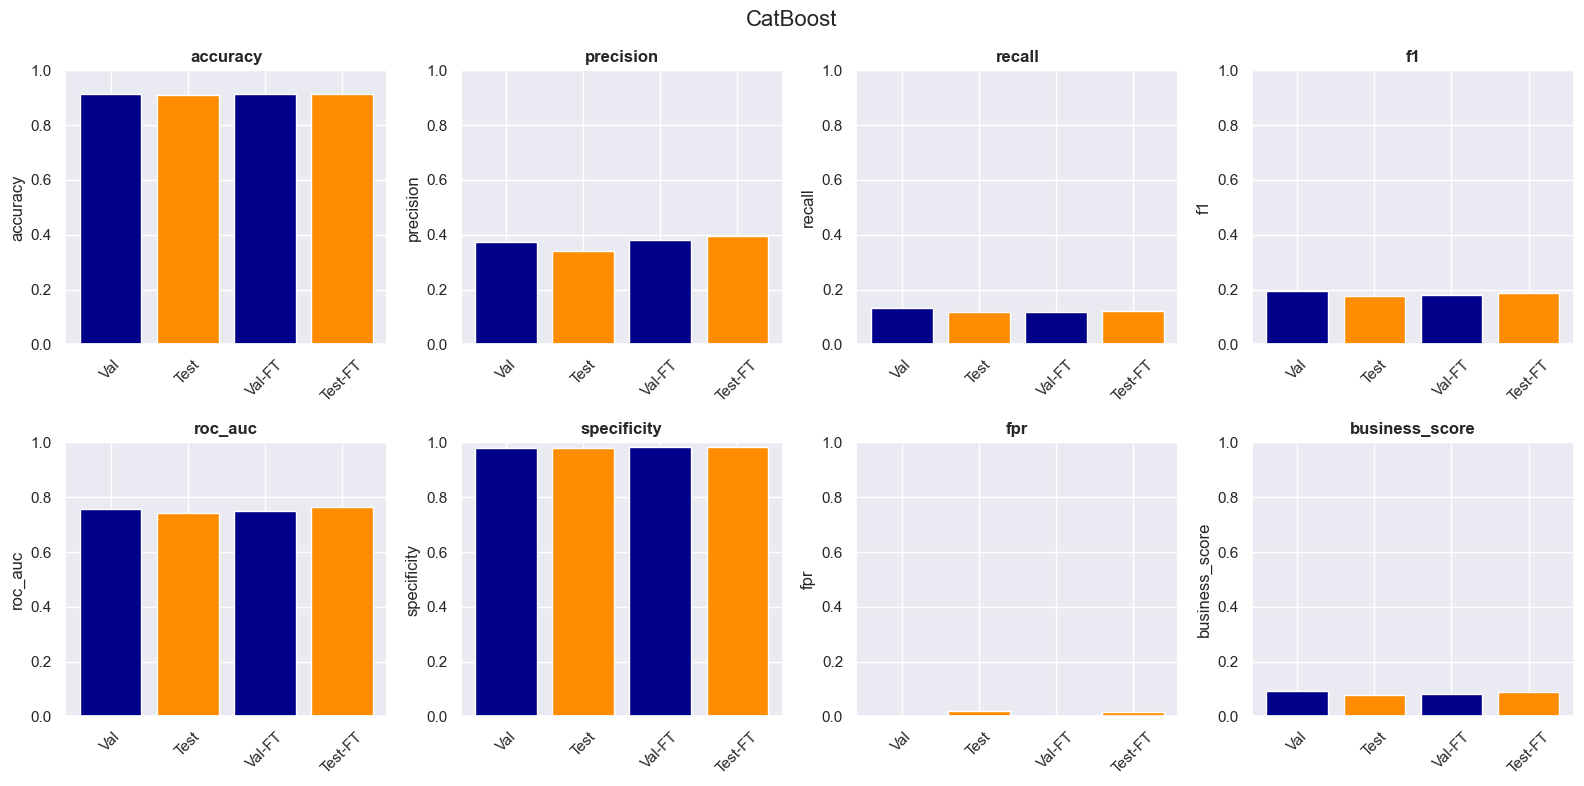

In [59]:
models = {'lr': 'LogisticRegression', 
          'rf': 'RandomForest', 
          'xgbc': 'XGBoost', 
          'lgbmc': 'LightGBM', 
          'cbc': 'CatBoost'}

for model, name in models.items():
    train_results = globals()[model + '_results_cv']
    test_results = globals()[model + '_results_test']
    train_results_ft = globals()[model + 't_results_cv']
    test_results_ft = globals()[model + 't_results_test']
    plot_metrics_dual_per_model(name, train_results, test_results, train_results_ft, test_results_ft)

XGBoost and LightGBM are the best models regarding Business score and Accuracy.
However, **LightGBM** was chosen because it takes a shorter time to train.

In [60]:
# Get best params of LigthGBM and fine tune around them + new hyper parameters

lgbmct_model.named_steps['classifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'cpu'}

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.228373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91243
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91592
[LightGBM] [Info] Number of 

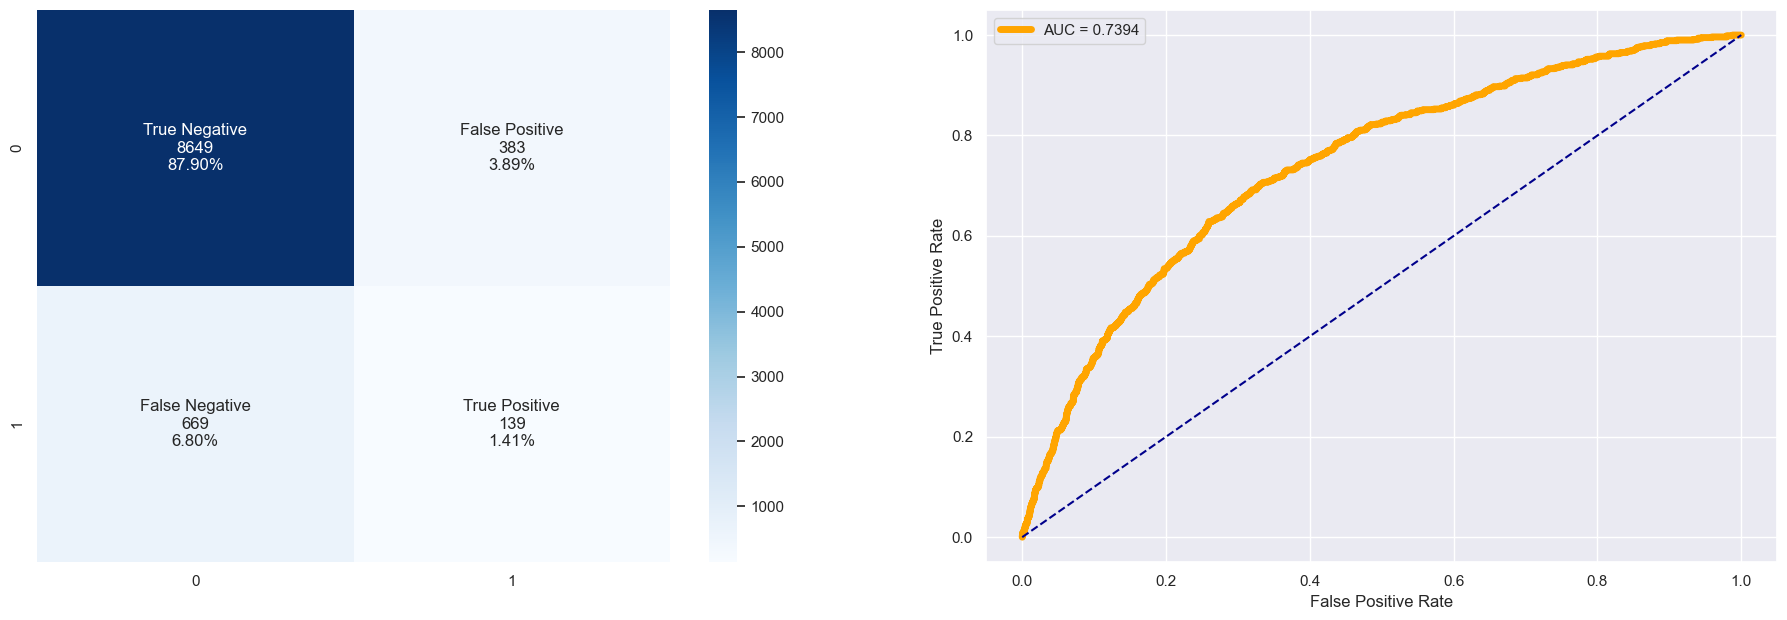

In [61]:
# Fine tune the best model around best params
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned_2'

# Set hyperparameter grid
param_grid = { 
    'classifier__n_estimators': [x for x in range(100, 350, 50)],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
    'classifier__num_leaves': [x for x in range(20, 51, 5)]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2, n_iter=120)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
[LightGBM] [Info] Number of positive: 72369, number of negative: 72369
[LightGBM] [Info] Number of positive: 72369, number of negative: 72369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.751832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106272
[LightGBM] [Info] Number of data points in the train set: 144738, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.439704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106362
[LightGBM] [Info] Number of data points in the train set: 144738, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> i

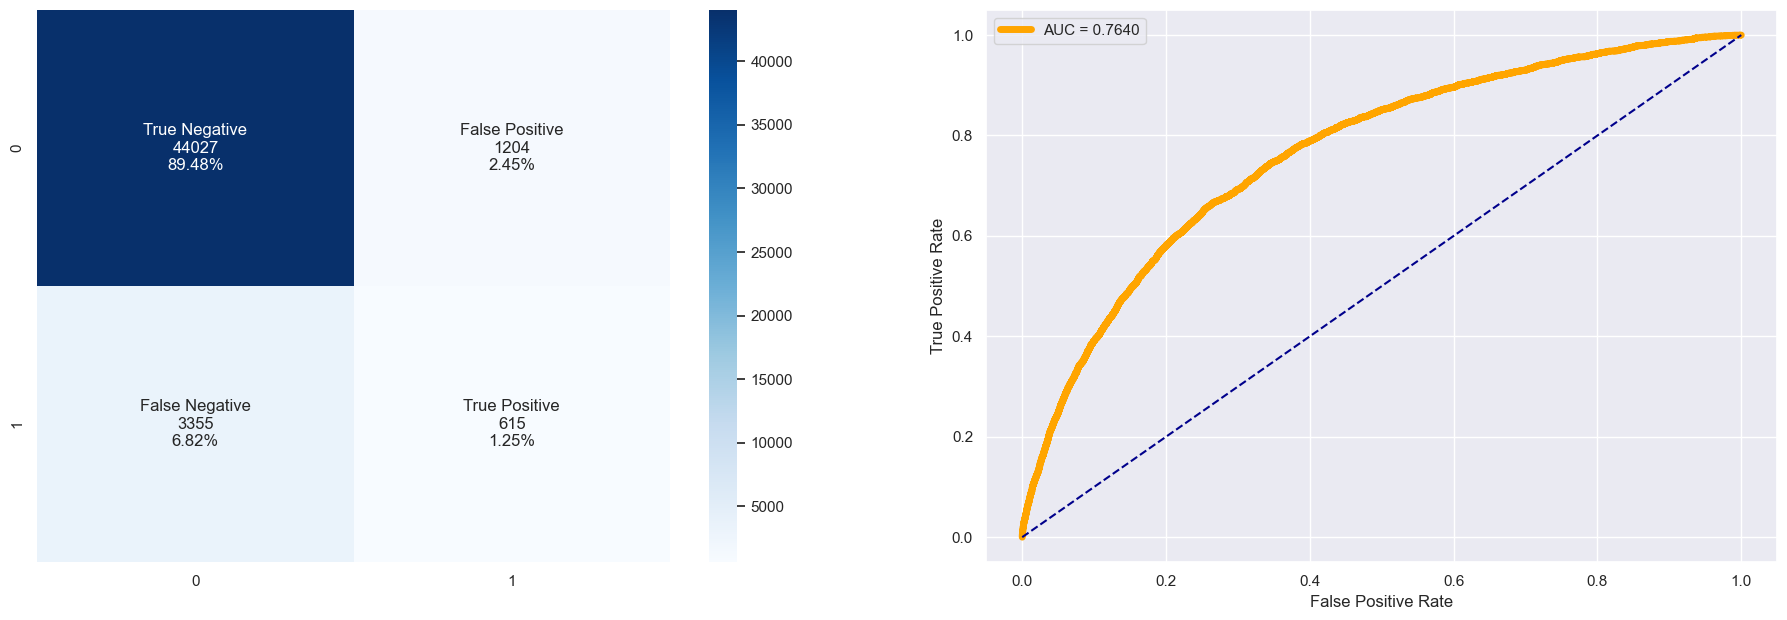

In [62]:
# Train the best model with the whole train dataset
%time
# Get the best params 
best_params = lgbmct_model.named_steps['classifier'].get_params()

# Create LightGBM classifier
lgbmc_final = LGBMClassifier(**best_params)
lgbmc_final_name = 'LightGBM_final'

# Compute results 
lgbmc_final_model, lgbmc_final_results_cv, lgbmc_final_results_test = train_model(lgbmc_final_name, lgbmc_final, cv=5)

In [63]:
lgbmc_final_results_cv

{'accuracy': 0.9070491765248627,
 'precision': 0.35106222851561475,
 'recall': 0.1790302267002519,
 'f1': 0.23708852732003746,
 'roc_auc': 0.7652438869315465,
 'specificity': 0.9709489564506419,
 'fpr': -0.029051043549357957,
 'business_score': 0.11885161438058164,
 'fit_time': 118.88376970291138,
 'execution_time': 124.4253339767456}

In [64]:
lgbmc_final_results_test

{'fit_time': 29.352233171463013,
 'accuracy': 0.9073392817219162,
 'precision': 0.33809785596481584,
 'recall': 0.15491183879093198,
 'f1': 0.2124719295215063,
 'roc_auc': 0.7639956145634051,
 'specificity': 0.9733810881917269,
 'fpr': 0.026618911808273086,
 'business_score': 0.0997710098465766}

#### Threshold selection

In [65]:
def threshold_selection(y_test, y_prob):
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = business_loss_func(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

In [66]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:

        # Compute best threshold
        o_tpr = tpr[np.argmax(tpr - fpr)]
        o_fpr = fpr[np.argmax(tpr - fpr)]
        o_threshold = thresholds[np.argmax(tpr - fpr)]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [67]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [68]:
# Get proba predictions from xgbc model to be class 1 : repay failure
lgbmc_proba = lgbmc_final_model.predict_proba(x_test)[:,1]

Best results
- Best Threshold:	 0.277
- Best Score:		 0.198




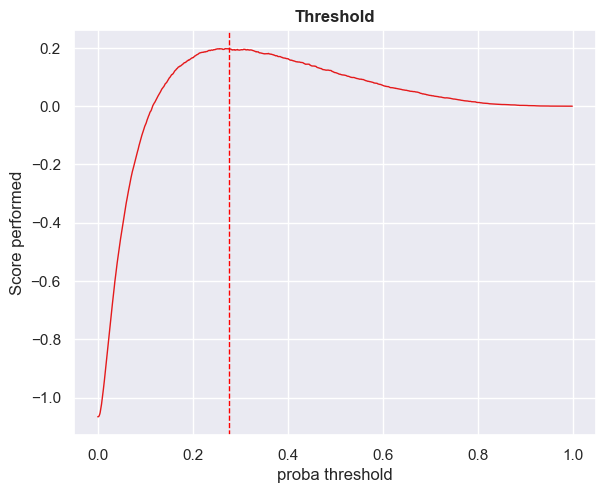

In [69]:
threshold = threshold_selection(y_test, lgbmc_proba)

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower. 
Here it gives us 0.274

Let's try different value of the prediction threshold : [0.5, 0.4, 0.3, 0.2, 0.1]

Printing results for threshold = 0.5
Business score = 0.1153403380539059


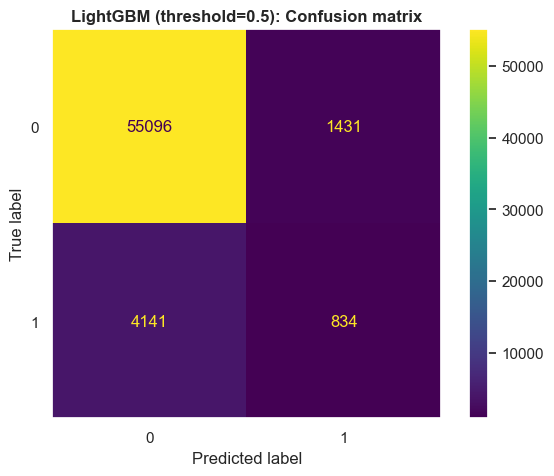

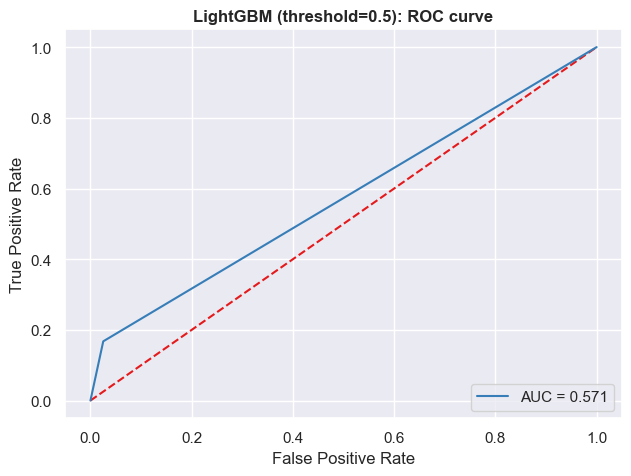

precision    recall  f1-score       support
0              0.930094  0.974685  0.951868  56527.000000
1              0.368212  0.167638  0.230387   4975.000000
accuracy       0.909401  0.909401  0.909401      0.909401
macro avg      0.649153  0.571161  0.591127  61502.000000
weighted avg   0.884643  0.909401  0.893506  61502.000000

Printing results for threshold = 0.3
Business score = 0.19329374143444494


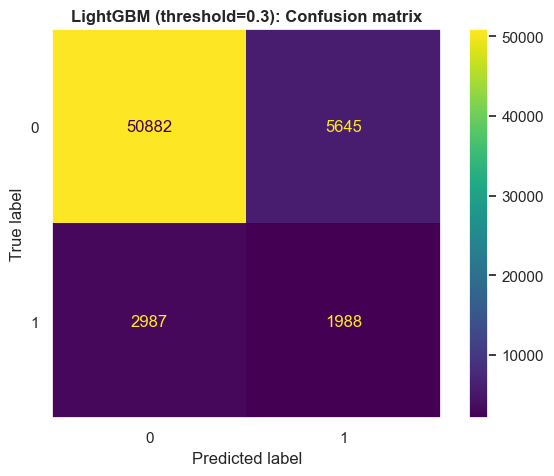

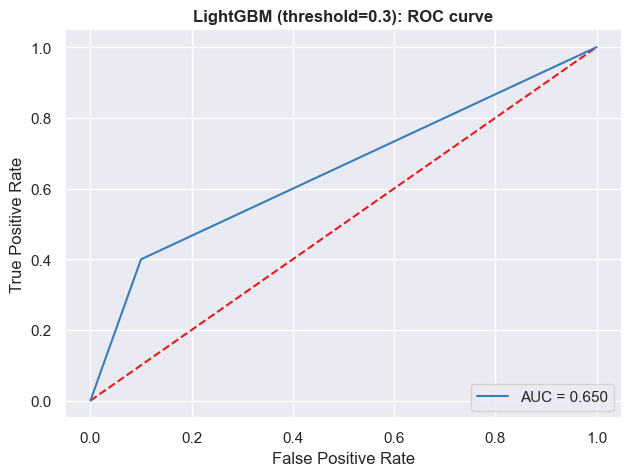

precision    recall  f1-score       support
0              0.944551  0.900136  0.921809  56527.000000
1              0.260448  0.399598  0.315355   4975.000000
accuracy       0.859647  0.859647  0.859647      0.859647
macro avg      0.602499  0.649867  0.618582  61502.000000
weighted avg   0.889212  0.859647  0.872752  61502.000000

Printing results for threshold = 0.277
Business score = 0.19767930561900413


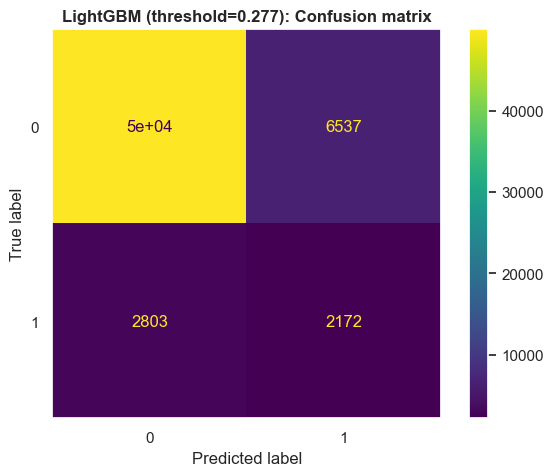

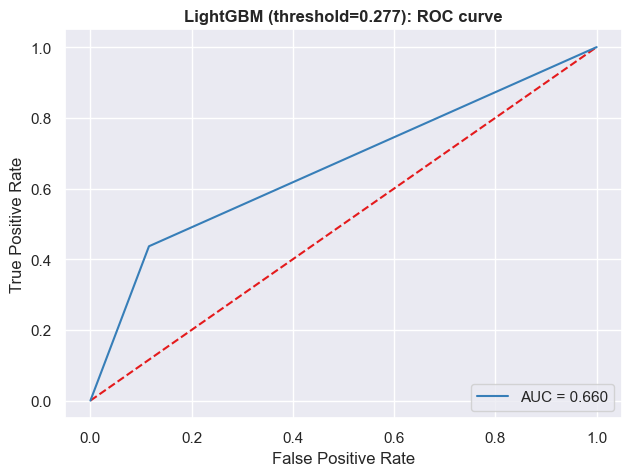

precision    recall  f1-score       support
0              0.946906  0.884356  0.914563  56527.000000
1              0.249397  0.436583  0.317451   4975.000000
accuracy       0.848135  0.848135  0.848135      0.848135
macro avg      0.598152  0.660470  0.616007  61502.000000
weighted avg   0.890483  0.848135  0.866261  61502.000000

Printing results for threshold = 0.2
Business score = 0.16665143901324805


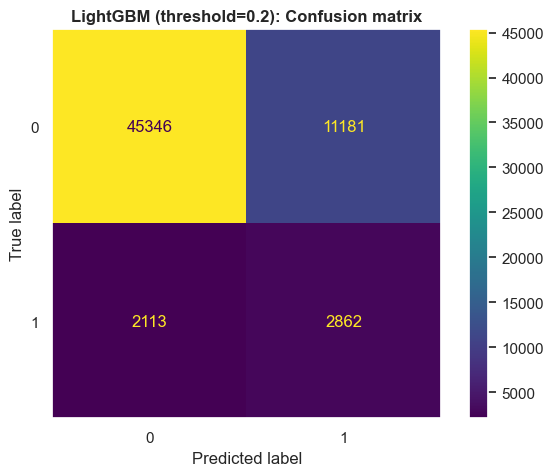

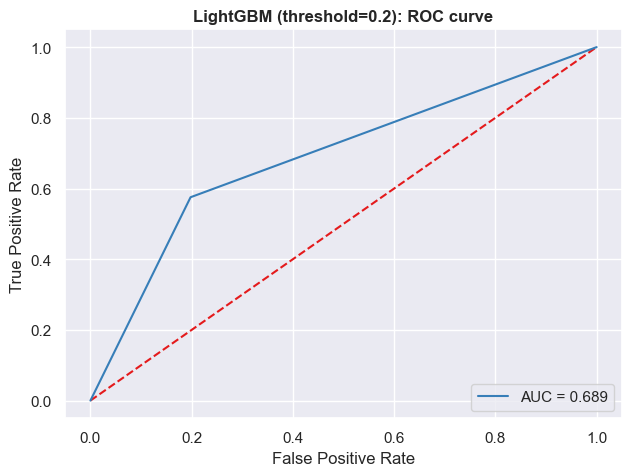

precision    recall  f1-score       support
0              0.955477  0.802201  0.872156  56527.000000
1              0.203803  0.575276  0.300978   4975.000000
accuracy       0.783844  0.783844  0.783844      0.783844
macro avg      0.579640  0.688739  0.586567  61502.000000
weighted avg   0.894673  0.783844  0.825952  61502.000000

In [70]:
for threshold in [0.5, 0.3, 0.277, 0.2]: 
    print(f'Printing results for threshold = {threshold}')
    lgbm_pred_std = lgbmc_proba >= threshold
    business_score = business_loss_func(y_test, lgbm_pred_std)
    print('Business score =', business_score)
    display_confusion_matrix(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    auc_score = compute_roc_curve(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    clf_report = pd.DataFrame(classification_report(y_test, lgbm_pred_std, output_dict=True)).transpose()
    display(clf_report)


#### Explainer / Feature importance

##### Global feature importance

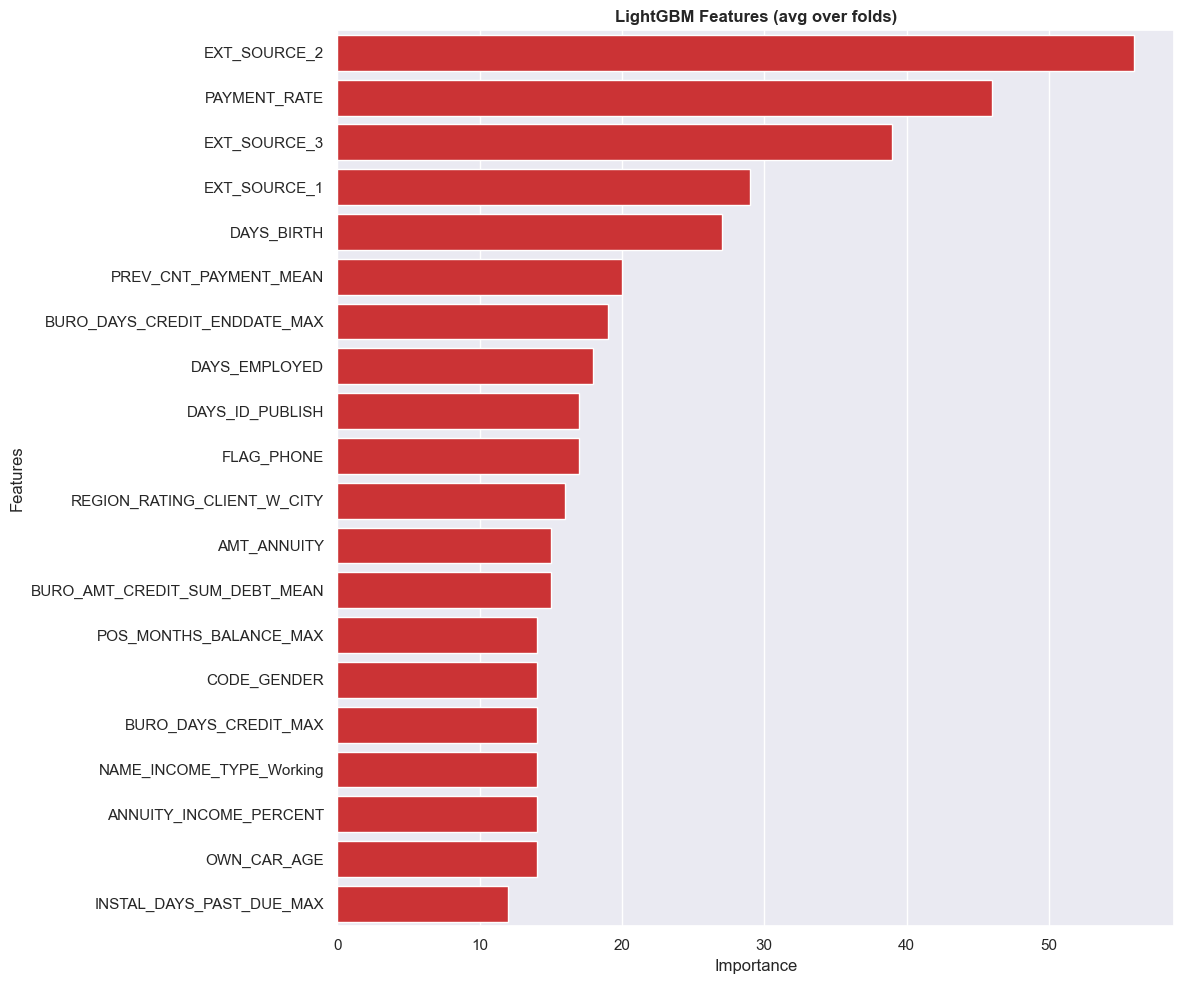

In [71]:
feature_importance_df_ = pd.DataFrame({'importance': lgbmc_final_model.steps[2][1].feature_importances_, 
                                       'feature': x_train.columns})

cols = feature_importance_df_[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:20].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()
plt.show()

##### Local feature importance (SHAP)

In [72]:
shap_explainer = shap.TreeExplainer(lgbmc_final_model.steps[2][1])
shap_values = shap_explainer.shap_values(x_test)

In [83]:
idx = 1000

shap.initjs()
shap.force_plot(shap_explainer.expected_value[0], 
                shap_values[0][idx, :], 
                x_train.iloc[idx, :])

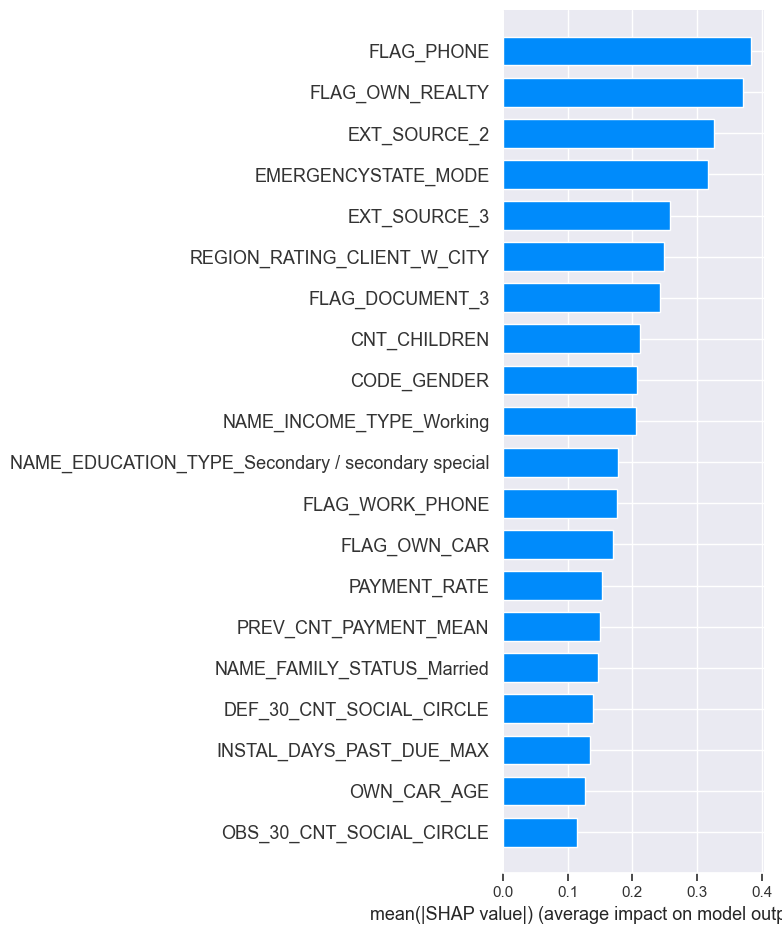

In [81]:
shap.summary_plot(shap_values[0], x_test, plot_type='bar')

#### Export

In [75]:
# Final model

filename = 'models/lightgbm_classifier.pkl'
pickle.dump(lgbmc_final_model.steps[2][1], open(filename, 'wb'))

In [76]:
# SHAP explainer

filename = 'models/lightgbm_shap_explainer.pkl'
pickle.dump(shap_explainer, open(filename, 'wb'))